## Eeg Classification

The following notebook summaries the main training pipeline for the EEG classification task.

## Import libraries

In [1]:
import pandas as pd
import gc
import numpy as np
np.random.seed(0)
import json
import os
import torch
from tqdm import tqdm

import glob
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
local = True

if not local:
    from google.colab import drive
    drive.mount('/content/drive')#, force_remount=True)
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

## Important properties

In [3]:
votes_cols = [
    "seizure_vote",
    "lpd_vote",
    "gpd_vote",
    "lrda_vote",
    "grda_vote",
    "other_vote",
]
N_classes = len(votes_cols)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not train_on_gpu:
    print("CUDA is not available.  Training on CPU.")
else:
    print("CUDA is available!  Training on GPU.")
    print("GPU count", torch.cuda.device_count())

if local:
    dir = "C:\\Users\\Amy\\Desktop\\Green_Git\\eegClassification\\"
    # Path to data subfolder
    path = dir+"data/data/"
    # Path to output to
    path_out = dir+"models/"
    # Path to save temporary data
    save_path = dir+"data/tmp/"
    # path to train data file
    path_df = dir+"sample_data\\"
else:
    # specify paths for google colab
    dir = "/content/drive/MyDrive/Sun/ML Shock/Final project/"
    # Path to data subfolder
    path = dir+"data/"
    # Path to output to
    path_out = dir+"models/"
    # Path to save temporary data
    save_path = dir+"data/tmp/"
    # path to train data file
    path_df = dir+"data/"


# if path does not exist create it
if not os.path.exists(path_out):
    os.makedirs(path_out)

# number of subprocesses to use for data loading
# import multiprocessing as cpu
num_workers = 0  # cpu.cpu_count()  # - 1 #
# how many samples per batch to load
batch_size = 64  # 8  #
# Is a test?
test = False  # True  #

CUDA is not available.  Training on CPU.


## Custom Dataloader

In [4]:
from torch.utils.data import Dataset
import pyarrow.parquet as pq
from scipy.signal import spectrogram

### Custom dataset for preprocessing the data

It would be time consuming to preprocess the data every time the data is loaded. Instead, I preprocess the data once and save it in a file. This way, we can load the preprocessed data directly from the file.

In [5]:
def transpose_stack(x):
    return x.transpose(0, 1).reshape(299, 400).transpose(0, 1)


def transpose_stack_eeg_spec(x):
    return x.transpose(0, 1).reshape(129, 7 * 20).transpose(0, 1)


def normalize(x):
    # Calculate mean and standard deviation once
    mean = torch.mean(x)
    std = torch.std(x)
    # Avoid reshaping multiple times
    x_flat = x.reshape(1, -1)
    # Normalize using calculated mean and std
    return (x_flat - mean) / std


def tile(x):
    return torch.tile(x, (3, 1, 1))


def normalize_special(x):
    # Use broadcasting to avoid unnecessary reshape operations
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
    return (x * std - mean).reshape(3, 400, 299)


def normalize_special_eeg_spec(x):
    # Use broadcasting to avoid unnecessary reshape operations
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
    return (x * std - mean).reshape(3, 7 * 20, 129)


def min_max_scaling(x):
    # Calculate min and max once
    min_val = torch.min(x, dim=1).values.unsqueeze(1)
    max_val = torch.max(x, dim=1).values.unsqueeze(1)

    # Normalize using calculated min and max
    return torch.div(x - min_val, max_val - min_val)


class CustomDataset(Dataset):
    def __init__(
        self,
        data_dir,
        data_type,
        data_info_dict,
        transform=None,
    ):
        """
        A custom data loader for the harmful brain activity dataset.
        CustomDataset inherits from torch.utils.data.Dataset
        and overrides the __len__ and __getitem__ methods.

        Parameters
        ----------
        data_dir : str
            The directory where the data is stored.
        data_type : str
            The type of data to load. Must be one of ['spec', 'eeg_raw', 'eeg_spec'].
        data_info_dict : dict
            A dictionary containing the data information. The keys are tuples of the form
            (data_id, item_id, offset) and the values are dictionaries containing the votes
            for each class.
        """

        self.data_dir = data_dir

        self.data_type = data_type

        if self.data_type not in ["eeg_spec", "spec", "eeg_raw"]:
            raise ValueError(
                "Invalid data type provided. Must be one of ['spec', 'eeg_raw', 'eeg_spec']"
            )

        if transform is None and self.data_type == "spec":
            self.transform = (
                torch.tensor,
                transpose_stack,
                normalize,
                tile,
                normalize_special,
            )
        elif transform is None and self.data_type == "eeg_spec":
            self.transform = (
                torch.tensor,
                transpose_stack_eeg_spec,
                normalize,
                tile,
                normalize_special_eeg_spec,
            )
        else:
            self.transform = transform

        self.item_list = [k for k in data_info_dict.keys()]
        self.data_info_dict = data_info_dict

    def __len__(self):
        return len(self.item_list)

    def __getitem__(self, idx):

        item = self.item_list[idx]
        data_id, _, offset = item
        path = self.data_dir + str(data_id) + ".parquet"

        data = self.preprocessing(path, offset)

        class_votes = self.data_info_dict[item]["votes"]
        if class_votes is None:
            class_votes = np.array([])
            label = np.array([])
        else:
            label = np.argmax(class_votes)

        if self.transform:
            for trans in self.transform:
                data = trans(data)

        return data, class_votes

    def preprocessing(self, path, offset):
        freq = 200 if "eeg" in self.data_type else 0.5  # Hz

        data = pq.read_table(path).to_pandas()

        # fill nan with zeros
        data = data.fillna(0)
        # enforce data type to float32
        data = data.astype(np.float32)

        collected_data = []
        if self.data_type == "spec":
            for spec_type in ["LL", "RL", "LP", "RP"]:
                collected_data.append(data.filter(regex=spec_type).values)
        elif self.data_type in ["eeg_raw", "eeg_spec"]:
            for col in data.columns:
                collected_data.append(data[col].values)

        data = np.moveaxis(np.array(collected_data), 0, -1)

        if self.data_type == "spec":
            start = int((0 + offset) * freq)
            end = int((600 + offset) * freq) - 1

            # clip values between exp(-4) and exp(8)
            data = np.clip(data[start:end, :], np.exp(-4), np.exp(8))
            data = np.log(data)
            # move last axis to first
            data = np.moveaxis(data, -1, 0)
        elif self.data_type == "eeg_raw":

            # # select the central 50 seconds of the data
            # start = int((0 + offset) * freq)
            # end = int((49 + offset) * freq)
            # select the central 10 seconds of the data
            start = int((20 + offset) * freq)
            end = int((29 + offset) * freq)

            data = data[start:end]
            # move last axis to first
            data = np.moveaxis(data, -1, 0)
        elif self.data_type == "eeg_spec":

            # # select the central 50 seconds of the data
            # start = int((0 + offset) * freq)
            # end = int((49 + offset) * freq)
            # select the central 10 seconds of the data
            start = int((20 + offset) * freq)
            end = int((29 + offset) * freq)

            data = data[start:end]
            # apply spectrogram to across all channels, axis 0
            spec_data = []
            for d in range(data.shape[1]):
                _, _, Sxx = spectrogram(data[:, d], fs=freq)
                # clip
                Sxx = np.clip(Sxx, np.exp(-4), np.exp(8))
                spec_data.append(np.log(Sxx))

            data = np.moveaxis(np.array(spec_data), 0, -1)
            data = np.array(spec_data)
        else:
            raise ValueError(
                "Invalid data type provided. Must be one of ['spec', 'eeg_raw', 'eeg_spec']"
            )

        return data

### Custom dataset for loading the saved preprocessed data

In [6]:
class CustomDatasetNPY(Dataset):
    def __init__(
        self,
        data_path,
        data_files,
        transform=None,
    ):
        self.data_path = data_path
        self.data_files = data_files
        self.N_items = len(self.data_files)
        self.transform = transform

    def __len__(self):
        return self.N_items

    def __getitem__(self, idx):

        idx = self.data_files[idx]
        # read data from path, npy
        data = np.load(self.data_path + "images_" + str(idx) + ".npy")
        class_votes = np.load(self.data_path + "votes_" + str(idx) + ".npy")

        if self.transform:
            batch_size = data.shape[0]
            for trans in self.transform:
                data = trans(batch_size, data)

        return data, class_votes

## Model Architectures

Various model architectures are implemented in the following cells. These can be tested for different data types. 

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# define the CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, input_shape, N_classes, batch_size=64):
        super(CustomCNN, self).__init__()

        self.input_shape = input_shape
        self.N_classes = N_classes
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(self.input_shape[0], 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.N_out = (
            8
            * (self.input_shape[1] // 2 // 2 // 2)
            * (self.input_shape[2] // 2 // 2 // 2)
        )
        self.fc1 = nn.Linear(self.N_out, 500)
        # linear layer (500 -> 6)
        self.fc2 = nn.Linear(500, self.N_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(x.shape[0], self.N_out)  # x.view(self.batch_size, self.N_out)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)

        return x


# define the CNN architecture
class CustomCNN_eeg(nn.Module):
    def __init__(self, input_shape, N_classes, batch_size=64):
        super(CustomCNN_eeg, self).__init__()

        self.input_shape = input_shape
        self.N_classes = N_classes
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(self.input_shape[0], 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.N_out = (
            8
            * (self.input_shape[1] // 2 // 2 // 2)
            * (self.input_shape[2] // 2 // 2 // 2)
        )
        self.fc1 = nn.Linear(self.N_out, 500)
        # linear layer (500 -> 6)
        self.fc2 = nn.Linear(500, self.N_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(x.shape[0], self.N_out)  # x.view(self.batch_size, self.N_out)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)

        return x


class CustomCNN_eeg_small(nn.Module):
    def __init__(self, input_shape, N_classes, batch_size=64):
        super(CustomCNN_eeg_small, self).__init__()

        self.input_shape = input_shape
        self.N_classes = N_classes
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(self.input_shape[0], 4, 4, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.N_out = (
            8
            * (self.input_shape[1] // 2 // 2 // 2)
            * (self.input_shape[2] // 2 // 2 // 2)
        )
        self.fc1 = nn.Linear(self.N_out, 500)
        # linear layer (500 -> 6)
        self.fc2 = nn.Linear(500, self.N_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(x.shape[0], self.N_out)  # x.view(self.batch_size, self.N_out)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)

        return x


# define the CNN architecture
class TransNet_Resnet18(nn.Module):
    def __init__(self, input_shape, N_classes):
        super(TransNet_Resnet18, self).__init__()

        self.input_shape = input_shape

        self.N_classes = N_classes

        self.model = models.resnet18(pretrained=True)

        in_features = self.model.fc.in_features

        # freeze all model parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # remove the last layer
        self.model.fc = nn.Identity()

        # a layer to go some shape (4,299,100) to (3,299,100)
        # self.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # replace first layer with new layer
        # self.model.conv1 = self.conv1

        # add new layer
        # self.fc = nn.Linear(in_features, self.N_classes)

    def forward(self, x):
        x = self.model(x)
        # x = F.log_softmax(self.fc(x), dim=1)

        return x


# define the CNN architecture
class TransNet_Efficientnetb0(nn.Module):
    def __init__(self, input_shape, N_classes):
        super(TransNet_Efficientnetb0, self).__init__()

        self.N_classes = N_classes

        self.model = models.efficientnet_b0(pretrained=True)
        in_features = self.model.classifier[-1].in_features

        # freeze all model parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # # remove the last layer
        self.model.classifier[-1] = nn.Identity()

        # a layer to go some shape (4,299,100) to (3,299,100)
        # self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # replace first layer with new layer
        # self.model.features[0] = self.conv1

        # add new layer
        # self.fc = nn.Linear(in_features, self.N_classes)

    def forward(self, x):
        x = self.model(x)
        # x = F.log_softmax(self.fc(x), dim=1)

        return x


class TransNet_Resnet18_unfrozen(nn.Module):
    def __init__(self, input_shape, N_classes):
        super(TransNet_Resnet18_unfrozen, self).__init__()

        self.input_shape = input_shape

        self.N_classes = N_classes

        self.model = models.resnet18(pretrained=True)

        in_features = self.model.fc.in_features

        # freeze all model parameters
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # remove the last layer
        self.model.fc = nn.Identity()

        # a layer to go some shape (4,299,100) to (3,299,100)
        # self.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # replace first layer with new layer
        # self.model.conv1 = self.conv1

        # add new layer
        self.fc = nn.Linear(in_features, self.N_classes)

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(self.fc(x), dim=1)

        return x


# define the CNN architecture
class TransNet_Efficientnetb0_unfrozen(nn.Module):
    def __init__(self, input_shape, N_classes):
        super(TransNet_Efficientnetb0_unfrozen, self).__init__()

        self.N_classes = N_classes

        self.model = models.efficientnet_b0(pretrained=True)
        in_features = self.model.classifier[-1].in_features

        # freeze all model parameters
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # # remove the last layer
        self.model.classifier[-1] = nn.Identity()

        # a layer to go some shape (4,299,100) to (3,299,100)
        # self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # replace first layer with new layer
        # self.model.features[0] = self.conv1

        # add new layer
        self.fc = nn.Linear(in_features, self.N_classes)

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(self.fc(x), dim=1)

        return x



## Helper functions

In [8]:
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [23]:

# all the model architectures
# module = __import__("model_architectures")


get_batch_transform = lambda x, y: (
    x[0, :],
    y[0, :],
)


def get_data_info(df, data_type):

    # train is true id votes_cols are available
    train = all([col in df.columns for col in votes_cols])

    label_cols = (
        ["eeg_id", "label_id", "eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_id", "label_id", "spectrogram_label_offset_seconds"]
    )
    offset = (
        ["eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_label_offset_seconds"]
    )

    # if info_cols not in df add it and set to zero
    for col in offset:
        if col not in df.columns:
            df[col] = 0
    # if df does not contain "label_id" add a unique label_id
    if "label_id" not in df.columns:
        df["label_id"] = range(len(df))

    info = {}
    df_gr = df.groupby(label_cols)
    for name, group in df_gr:
        # first row of group
        info[name] = {"votes": group[votes_cols].values[0] if train else None}

    return info


def shuffle(info):
    info_shuffled = {}
    keys = [k for k in info.keys()]
    np.random.shuffle(keys)
    for key in keys:
        info_shuffled[key] = info[key]

    return info_shuffled


def egg_spec_augmentation(info, rates=[0.75, 0.2, 0.2, 0.2, 0.2, 0.2]):

    info_aug = info.copy()

    offset = [-1, 1, -2, 2, -3, 3, -4, 4]
    keys = [k for k in info_aug.keys()]
    N_item = len(keys)

    counts = [0] * 6
    for k in info_aug.keys():
        idx = np.argmax(info_aug[k]["votes"])
        counts[idx] += 1

    for key in keys:
        # generate random between 0 and 1
        r = np.random.rand()
        idx = np.argmax(info_aug[key]["votes"])

        if r < rates[idx]:
            # select a random offset
            off = np.random.choice(offset)
            new_key = (key[0], key[1], key[2] + off)
            # if new_key not in info add it
            if new_key not in info_aug.keys():
                info_aug[new_key] = info_aug[key]

            counts[idx] += 1

        # if len(info) >= N_item*(1+0.4):
        #     break

    return info_aug


def lrfn(
    epoch,
    epochs,
    mode="cos",
    lr_start=2e-4,
    lr_max=3e-5 * 64,
    lr_min=1e-5,
    lr_ramp_ep=4,
    lr_sus_ep=0,
    lr_decay=0.75,
):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    elif mode == "exp":
        lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    elif mode == "step":
        lr = lr_max * lr_decay ** ((epoch - lr_ramp_ep - lr_sus_ep) // 2)
    elif mode == "cos":
        decay_total_epochs, decay_epoch_index = (
            epochs - lr_ramp_ep - lr_sus_ep + 3,
            epoch - lr_ramp_ep - lr_sus_ep,
        )
        phase = np.pi * decay_epoch_index / decay_total_epochs
        lr = (lr_max - lr_min) * 0.5 * (1 + np.cos(phase)) + lr_min
    return lr


def train_func(
    model,
    train_loader,
    valid_loader,
    path_model_out,
    n_epochs,
    learning_rate,
    label_smoothing,
    test=False,
    valid_loss_min=np.Inf,
    loss_type = "cross_entropy",
):
    
    if loss_type == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_type == "kldiv":
        criterion = nn.KLDivLoss(reduction="batchmean", log_target=True)
    else:
        raise ValueError("Loss not found")
    
    optimizer = optim.Adam(model.parameters())

    track_loss = []
    track_loss_val = []

    max_samples = 1

    train_on_gpu = torch.cuda.is_available()

    for epoch in range(1, n_epochs + 1):

        for g in optimizer.param_groups:
            g["lr"] = learning_rate[epoch - 1]  # lrfn(epoch, n_epochs)
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        count = 0

        for data, votes in tqdm(train_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # offset vote by adding label smoothing as offset
            votes = votes * (1 - label_smoothing) + label_smoothing / N_classes

            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            if torch.isnan(output).sum() > 0:
                #print("Nan in output")
                pass
            else:

                # loss
                if loss_type == "cross_entropy":
                    loss = criterion(torch.exp(output), torch.argmax(votes, axis=1))
                elif loss_type == "kldiv":
                    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
                else:
                    raise ValueError("Loss not found")

                # update training loss
                train_loss += loss.item()  # *data.size(0)

                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()

                optimizer.step()

                count += 1

        train_loss = train_loss / count  # len(train_loader)#/batch_size

        torch.cuda.empty_cache()
        ######################
        # validate the model #
        ######################
        model.eval()
        count = 0
        for data, votes in tqdm(valid_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            if torch.isnan(output).sum() > 0:
                print("Nan in output")
            else:
                # calculate the batch loss
                if loss_type == "cross_entropy":
                    loss = criterion(torch.exp(output), torch.argmax(votes, axis=1))
                elif loss_type == "kldiv":
                    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
                else:
                    raise ValueError("Loss not found")

                # update average validation loss
                valid_loss += loss.item()  # *data.size(0)

                count += 1

        torch.cuda.empty_cache()
        # calculate average losses

        valid_loss = valid_loss / count  # len(valid_loader)#/batch_size

        track_loss.append(train_loss)
        track_loss_val.append(valid_loss)

        # print training/validation statistics
        print("{}; \t{:.6f}; \t{:.6f}".format(epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), path_model_out)
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            valid_loss_min = valid_loss

        gc.collect()

    return track_loss, track_loss_val


def create_data_loaders(
    path,
    df,
    train_p,
    test_p,
    data_type,
    min_votes,
    augmentation,
    batch_size=64,
    num_workers=0,
):
    data_dir = f"train_eegs/" if "eeg" in data_type else f"train_spectrograms/"
    data_dir = path + data_dir

    df_test = df[df["patient_id"].isin(test_p)]
    print("Fetching info...")
    info_test = get_data_info(df_test, data_type)

    dataset_test = CustomDataset(data_dir, data_type, info_test)
    test_loader = DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    # split train_p into train and validation
    split = int(0.8 * len(train_p))
    train_p, valid_p = train_p[:split], train_p[split:]

    df_train = df[df["patient_id"].isin(train_p)]
    df_train = df_train[df_train["total_votes"] >= min_votes]
    info_train = get_data_info(df_train, data_type)
    info_train = shuffle(info_train)

    if augmentation:
        info_train_aug = egg_spec_augmentation(info_train)
    else:
        info_train_aug = info_train.copy()

    df_valid = df[df["patient_id"].isin(valid_p)]
    # df_valid = df_valid[df_valid["total_votes"] >= min_votes]
    info_valid = get_data_info(df_valid, data_type)
    info_valid = shuffle(info_valid)

    print("Creating data loaders...")
    train_dataset = CustomDataset(data_dir, data_type, info_train_aug)
    valid_dataset = CustomDataset(data_dir, data_type, info_valid)

    # prepare data loaders (combine dataset and sampler)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, num_workers=num_workers
    )

    return train_loader, valid_loader, test_loader


def run(
    path_out,
    model_name,
    label_smoothing,
    input_shape,
    n_epochs,
    model_info,
    train_loader,
    valid_loader,
    test_loader,
    is_test=False,
    loss_type="cross_entropy",
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_on_gpu = torch.cuda.is_available()

    # get model name as executable function
    # model = getattr(module, model_name)(input_shape=input_shape, N_classes=N_classes)
    model = globals()[model_name](input_shape=input_shape, N_classes=N_classes)


    if train_on_gpu:
        model.cuda()

    num_parameters = sum(p.numel() for p in model.parameters())
    # print("Number of parameters in the model", num_parameters)
    model_info["num_parameters"] = num_parameters

    # number of trainable parameters
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print("Number of trainable parameters in the model", num_parameters)
    model_info["num_trainable_parameters"] = num_parameters

    # check if "f"./model_{model_name}_*" exists and add 1 to the index
    index = 0
    model_path = path_out + "model_{model_name}_{index}.pt"
    while os.path.exists(model_path.format(model_name=model_name, index=index)):
        index += 1

    configs = {
        "n_epochs": n_epochs,
        "path_model_out": path_out + f"model_{model_name}_{index}.pt",
        "learning_rate": [lrfn(epoch, n_epochs) for epoch in np.arange(n_epochs)],
        "label_smoothing": label_smoothing,
        "loss_type": loss_type,
    }

    model_info["configs"] = configs
    model_info["model_name"] = model_name
    model_info["input_shape"] = input_shape

    valid_loss_min = (
        np.min(model_info["track_loss_val"])
        if len(model_info["track_loss_val"]) > 0
        else np.Inf
    )

    track_loss, track_loss_val = train_func(
        model,
        train_loader,
        valid_loader,
        valid_loss_min=valid_loss_min,
        test=is_test,
        **configs,
    )

    model_info["track_loss"] += track_loss
    model_info["track_loss_val"] += track_loss_val

    model.load_state_dict(torch.load(configs["path_model_out"]))

    if loss_type == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_type == "kldiv":
        criterion = nn.KLDivLoss(reduction="batchmean", log_target=True)
    else:
        raise ValueError("Loss not found")


    if test_loader is not None:

        # track test loss
        test_loss = 0.0
        test_loss_baseline = 0.0
        class_correct = list(0.0 for i in range(N_classes))
        class_total = list(0.0 for i in range(N_classes))
        model.eval()

        max_samples = 1
        cm_y_pred = []
        cm_y_true = []
        # iterate over test data
        count = 0
        for data, votes in tqdm(test_loader):
            if is_test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            if torch.isnan(output).sum() > 0:
                print("Nan in output")
            else:
                count += 1
                # calculate the batch loss
                if loss_type == "cross_entropy":
                    loss = criterion(torch.exp(output), torch.argmax(votes, axis=1))
                elif loss_type == "kldiv":
                    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
                else:
                    raise ValueError("Loss not found")

                test_loss += loss.item()  # *data.size(0)

                # dummy is a tensor filled with 1/6 of shape [64,6]
                dummy = torch.ones(data.size(0), N_classes).to(device)
                dummy = dummy / N_classes
                if loss_type == "cross_entropy":
                    loss_baseline = criterion(dummy, torch.argmax(votes, axis=1))
                elif loss_type == "kldiv":
                    loss_baseline = criterion(
                        F.log_softmax(dummy, dim=1), F.log_softmax(votes.float(), dim=1)
                    )
                else:
                    raise ValueError("Loss not found")

                test_loss_baseline += loss_baseline.item()

                # convert output probabilities to predicted class
                _, pred = torch.max(output, 1)
                # compare predictions to true label
                target = torch.argmax(votes, axis=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                correct = (
                    np.squeeze(correct_tensor.numpy())
                    if not train_on_gpu
                    else np.squeeze(correct_tensor.cpu().numpy())
                )
                # calculate test accuracy for each object class
                for i in range(target.shape[0]):
                    label = target.data[i]
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

                    cm_y_pred.append(pred[i].item())
                    cm_y_true.append(target.data[i].item())

        # average test loss
        test_loss = test_loss / count  # len(test_loader.dataset)  # /batch_size
        print("Test Loss: {:.6f}\n".format(test_loss))

        test_loss_baseline = (
            test_loss_baseline / count
        )  # len(test_loader.dataset)  # /batch_size
        print("Test Loss Baseline: {:.6f}\n".format(test_loss_baseline))

        cm = confusion_matrix(cm_y_true, cm_y_pred)
        cm_p = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        model_info["test_loss"] = test_loss
        model_info["test_loss_baseline"] = test_loss_baseline
        model_info["confusion_matrix"] = cm.tolist()
        model_info["confusion_matrix_p"] = cm_p.tolist()


def save_data(loaders, names, save_path, test=False):
    for data_loader, text in zip(
        loaders,
        names,
    ):
        tmp_path = save_path + f"{text}/"
        if not os.path.exists(tmp_path):
            os.makedirs(tmp_path)

        count = 0
        for X, votes in tqdm(data_loader, desc=f"Saving {text} data"):

            if test and count >= 3:
                break

            # save the images
            np.save(tmp_path + f"images_{count}.npy", X.numpy())
            # save the votes
            np.save(tmp_path + f"votes_{count}.npy", votes.numpy())
            count += 1


def run_inference(model_name, path_model_out, test_loader, input_shape, is_test=False, loss_type="cross_entropy"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_on_gpu = torch.cuda.is_available()

    # get model name as executable function
    # model = getattr(module, model_name)(input_shape=input_shape, N_classes=N_classes)
    model = globals()[model_name](input_shape=input_shape, N_classes=N_classes)
    # load trained model
    model.load_state_dict(torch.load(path_model_out))

    criterion = nn.KLDivLoss(reduction="batchmean", log_target=True)
    # criterion = nn.CrossEntropyLoss()

    # track test loss
    test_loss = 0.0
    test_loss_baseline = 0.0
    class_correct = list(0.0 for i in range(N_classes))
    class_total = list(0.0 for i in range(N_classes))
    model.eval()

    max_samples = 1
    cm_y_pred = []
    cm_y_true = []
    predictions = []
    labels = []
    # iterate over test data
    count = 0
    for data, votes in tqdm(test_loader):
        if is_test and count >= max_samples:
            break

        data, votes = get_batch_transform(data, votes)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, votes = data.cuda(), votes.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        if torch.isnan(output).sum() > 0:
            print("Nan in output")
        else:
            count += 1
            # calculate the batch loss
            # TODO: fix this
            if loss_type == "cross_entropy":
                loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
            elif loss_type == "kldiv":
                loss = criterion(torch.exp(output), torch.argmax(votes, axis=1))
            else:
                raise ValueError("Loss not found")

            test_loss += loss.item()  # *data.size(0)

            # dummy is a tensor filled with 1/6 of shape [64,6]
            dummy = torch.ones(data.size(0), N_classes).to(device)
            dummy = dummy / N_classes
            if loss_type == "cross_entropy":
                loss_baseline = criterion(
                    F.log_softmax(dummy, dim=1), F.log_softmax(votes.float(), dim=1)
                )
            elif loss_type == "kldiv":
                loss_baseline = criterion(dummy, torch.argmax(votes, axis=1))
            else:
                raise ValueError("Loss not found")

            test_loss_baseline += loss_baseline.item()

            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            target = torch.argmax(votes, axis=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = (
                np.squeeze(correct_tensor.numpy())
                if not train_on_gpu
                else np.squeeze(correct_tensor.cpu().numpy())
            )
            # calculate test accuracy for each object class
            for i in range(target.shape[0]):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

                cm_y_pred.append(pred[i].item())
                cm_y_true.append(target.data[i].item())

        predictions.append(output.cpu().detach().numpy())
        labels.append(votes.cpu().detach().numpy())

    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)

    accuracy = 100 * np.sum(class_correct) / np.sum(class_total)
    # print("Test Accuracy: {:.6f}%\n".format(accuracy))

    # average test loss
    test_loss = test_loss / count  # len(test_loader.dataset)  # /batch_size
    # print("Test Loss: {:.6f}\n".format(test_loss))

    test_loss_baseline = (
        test_loss_baseline / count
    )  # len(test_loader.dataset)  # /batch_size
    # print("Test Loss Baseline: {:.6f}\n".format(test_loss_baseline))

    cm = confusion_matrix(cm_y_true, cm_y_pred)
    cm_p = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    return accuracy, test_loss, test_loss_baseline, cm, cm_p, predictions, labels



### Get the training data info and load or create the data splits

In [10]:
df = pd.read_csv(path_df + f"train.csv")

df["total_votes"] = df[
    ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
].sum(axis=1)

# if path_out + "split.json" exist load it
if os.path.exists(path_out + "split.json"):
    with open(path_out + "split.json", "r") as f:
        split = json.load(f)
    train_p = np.array(split["train"])
    test_p = np.array(split["test"])
    print("Loaded train/test split")
else:
    p_id = df["patient_id"].unique()
    np.random.shuffle(p_id)
    # test train split
    train_p = p_id[: int(0.8 * len(p_id))]
    test_p = p_id[int(0.8 * len(p_id)) :]
    print("Created train/test split")

    # record the split in dict and save to json
    split = {"train": train_p.tolist(), "test": test_p.tolist()}
    with open(path_out + "split.json", "w") as f:
        json.dump(split, f)

Loaded train/test split


### Different training configurations

In [11]:
# # filter data, eg number of votes >5
# min_votes = [0, 5]
# # augment data (window shifting)
# augmentation = [False, True]
# # label smoothing
# label_smoothing = [0, 0.01]
# # number of epochs to train the model
# n_epochs = 40 if not test else 1
# # data type
# data_type = "eeg_spec"  
# # model name
# model_name = "CustomCNN_eeg"
# input_shape = (3, 140, 129)
# transform = tuple()

# # filter data for #votes >5
# min_votes = [0, 5]
# # augment data
# augmentation = [False]
# # label smoothing
# label_smoothing = [0, 0.01]
# # number of epochs to train the model
# n_epochs = 20 if not test else 1
# # data type
# data_type = "spec"  
# model_name = "CustomCNN"
# input_shape = (3, 400, 299)

# filter data, eg number of votes >5
min_votes = [0, 5]
# augment data (window shifting)
augmentation = [True, False]
# label smoothing
label_smoothing = [0, 0.01]
# number of epochs to train the model
n_epochs = 10 if not test else 1
# data type
data_type = "eeg_spec"  
# model name
model_name = "CustomCNN_eeg_small"
input_shape = (1, 140, 129)
# select one of the 3 channels
transform = (lambda batch_size, x: x[:, 0, :, :].reshape(batch_size, *input_shape),)


# # filter data, eg number of votes >5
# min_votes = [0, 5]
# # augment data (window shifting)
# augmentation = [False, True]
# # label smoothing
# label_smoothing = [0, 0.01]
# # number of epochs to train the model
# n_epochs = 8 if not test else 1
# # data type
# data_type = "eeg_spec"  # "eeg_raw" #"spec" #
# # model name
# model_name = "TransNet_Resnet18_unfrozen"
# input_shape = (3, 140, 129)
# transform = tuple()

### Run the training loop for the different configurations

In [12]:
first = True
for mv in min_votes:
    for aug in augmentation:

        train_loader, valid_loader, test_loader = create_data_loaders(
            path, df, train_p, test_p, data_type, mv, aug, batch_size, num_workers
        )

        if first:
            save_data(
                [train_loader, valid_loader, test_loader],
                [f"train_{data_type}", f"valid_{data_type}", f"test_{data_type}"],
                save_path,
                test,
            )
            first = False
        else:
            save_data([train_loader, valid_loader], [f"train_{data_type}", f"valid_{data_type}"], save_path, test)

        train_data = CustomDatasetNPY(
            save_path + f"train_{data_type}/",
            [str(i) for i in range(len(train_loader))],
            transform=transform,
        )
        train_loader = DataLoader(
            train_data, batch_size=1, shuffle=False, num_workers=num_workers
        )

        valid_data = CustomDatasetNPY(
            save_path + f"valid_{data_type}/",
            [str(i) for i in range(len(valid_loader))],
            transform=transform,
        )
        valid_loader = DataLoader(
            valid_data, batch_size=1, shuffle=False, num_workers=num_workers
        )

        # test_data = CustomDatasetNPY(
        #     save_path + f"test_{data_type}/",
        #     [str(i) for i in range(len(test_loader))],
        #     transform=transform,
        # )
        # test_loader = DataLoader(
        #     test_data, batch_size=1, shuffle=False, num_workers=num_workers
        # )

        test_loader = None

        for ls in label_smoothing:
            model_info = {}
            model_info["track_loss"] = []
            model_info["track_loss_val"] = []
            model_info["min_votes"] = mv
            model_info["augmentation"] = aug
            model_info["data_type"] = data_type

            run(
                path_out,
                model_name,
                ls,
                input_shape,
                n_epochs,
                model_info,
                train_loader,
                valid_loader,
                test_loader,
                is_test=test,
            )

            gc.collect()
            torch.cuda.empty_cache()

            # save model_info as json
            model_info_path = model_info["configs"]["path_model_out"].replace(
                ".pt", ".json"
            )
            with open(model_info_path, "w") as f:
                json.dump(model_info, f)

            print("Done")
            
        # permanently delete all files and folders in the train and valid tmp data folder
        for folder in [f"train_{data_type}/", f"valid_{data_type}/"]:
            for file in os.listdir(save_path + folder):
                os.remove(save_path + folder + file)



Fetching info...
Creating data loaders...


100%|██████████| 255/255 [00:10<00:00, 24.81it/s]


1; 	1.676988; 	1.679542
Validation loss decreased (inf --> 1.679542).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 24.75it/s]


2; 	1.606581; 	1.652841
Validation loss decreased (1.679542 --> 1.652841).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 24.61it/s]


3; 	1.542142; 	1.668178


100%|██████████| 255/255 [00:10<00:00, 24.53it/s]


4; 	1.490975; 	1.666094


100%|██████████| 255/255 [00:10<00:00, 24.56it/s]


5; 	1.452035; 	1.670370


100%|██████████| 255/255 [00:10<00:00, 24.85it/s]


6; 	1.418974; 	1.653873


100%|██████████| 255/255 [00:10<00:00, 24.76it/s]


7; 	1.392923; 	1.635065
Validation loss decreased (1.652841 --> 1.635065).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 24.59it/s]


8; 	1.374559; 	1.646075


100%|██████████| 255/255 [00:10<00:00, 24.77it/s]


9; 	1.354779; 	1.653111


100%|██████████| 255/255 [00:10<00:00, 24.81it/s]


10; 	1.341162; 	1.639183
Done


100%|██████████| 255/255 [00:10<00:00, 25.13it/s]


1; 	1.625735; 	1.676519
Validation loss decreased (inf --> 1.676519).  Saving model ...


100%|██████████| 255/255 [00:11<00:00, 22.97it/s]


2; 	1.539680; 	1.667979
Validation loss decreased (1.676519 --> 1.667979).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 24.42it/s]


3; 	1.499048; 	1.672880


100%|██████████| 255/255 [00:10<00:00, 25.19it/s]


4; 	1.473281; 	1.649282
Validation loss decreased (1.667979 --> 1.649282).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.51it/s]


5; 	1.462971; 	1.689534


100%|██████████| 255/255 [00:10<00:00, 23.64it/s]


6; 	1.441422; 	1.662990


100%|██████████| 255/255 [00:10<00:00, 24.58it/s]


7; 	1.415193; 	1.667743


100%|██████████| 255/255 [00:10<00:00, 25.06it/s]


8; 	1.393511; 	1.665677


100%|██████████| 255/255 [00:10<00:00, 25.14it/s]


9; 	1.369948; 	1.672474


100%|██████████| 255/255 [00:10<00:00, 25.48it/s]


10; 	1.354859; 	1.669030
Done
Fetching info...
Creating data loaders...


100%|██████████| 255/255 [00:10<00:00, 25.32it/s]


1; 	1.677937; 	1.702945
Validation loss decreased (inf --> 1.702945).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.43it/s]


2; 	1.582894; 	1.664072
Validation loss decreased (1.702945 --> 1.664072).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.48it/s]


3; 	1.516528; 	1.685473


100%|██████████| 255/255 [00:09<00:00, 25.61it/s]


4; 	1.479902; 	1.656043
Validation loss decreased (1.664072 --> 1.656043).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.73it/s]


5; 	1.461412; 	1.660889


100%|██████████| 255/255 [00:09<00:00, 25.75it/s]


6; 	1.433361; 	1.661267


100%|██████████| 255/255 [00:09<00:00, 25.82it/s]


7; 	1.411459; 	1.659545


100%|██████████| 255/255 [00:10<00:00, 25.20it/s]


8; 	1.393838; 	1.658414


100%|██████████| 255/255 [00:09<00:00, 25.79it/s]


9; 	1.375900; 	1.657262


100%|██████████| 255/255 [00:09<00:00, 25.67it/s]


10; 	1.360690; 	1.653904
Validation loss decreased (1.656043 --> 1.653904).  Saving model ...
Done


100%|██████████| 255/255 [00:09<00:00, 25.59it/s]


1; 	1.677581; 	1.713605
Validation loss decreased (inf --> 1.713605).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.67it/s]


2; 	1.602431; 	1.677925
Validation loss decreased (1.713605 --> 1.677925).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.57it/s]


3; 	1.555511; 	1.690890


100%|██████████| 255/255 [00:09<00:00, 25.89it/s]


4; 	1.517014; 	1.679359


100%|██████████| 255/255 [00:09<00:00, 25.69it/s]


5; 	1.489685; 	1.674595
Validation loss decreased (1.677925 --> 1.674595).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.61it/s]


6; 	1.465062; 	1.664188
Validation loss decreased (1.674595 --> 1.664188).  Saving model ...


100%|██████████| 255/255 [00:09<00:00, 25.87it/s]


7; 	1.440216; 	1.664942


100%|██████████| 255/255 [00:10<00:00, 25.05it/s]


8; 	1.417783; 	1.662651
Validation loss decreased (1.664188 --> 1.662651).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.02it/s]


9; 	1.398689; 	1.673124


100%|██████████| 255/255 [00:10<00:00, 25.05it/s]


10; 	1.382391; 	1.656412
Validation loss decreased (1.662651 --> 1.656412).  Saving model ...
Done
Fetching info...
Creating data loaders...


100%|██████████| 255/255 [00:10<00:00, 24.60it/s]


1; 	1.718600; 	1.802552
Validation loss decreased (inf --> 1.802552).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.36it/s]


2; 	1.627331; 	1.774744
Validation loss decreased (1.802552 --> 1.774744).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.22it/s]


3; 	1.571220; 	1.770518
Validation loss decreased (1.774744 --> 1.770518).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.42it/s]


4; 	1.536759; 	1.798206


100%|██████████| 255/255 [00:09<00:00, 25.51it/s]


5; 	1.507204; 	1.800430


100%|██████████| 255/255 [00:10<00:00, 25.46it/s]


6; 	1.479588; 	1.789003


100%|██████████| 255/255 [00:10<00:00, 25.41it/s]


7; 	1.437771; 	1.795976


100%|██████████| 255/255 [00:10<00:00, 25.45it/s]


8; 	1.412651; 	1.787869


100%|██████████| 255/255 [00:10<00:00, 25.41it/s]


9; 	1.387232; 	1.793376


100%|██████████| 255/255 [00:09<00:00, 25.50it/s]


10; 	1.370188; 	1.786176
Done


100%|██████████| 255/255 [00:10<00:00, 25.39it/s]


1; 	1.712389; 	1.809177
Validation loss decreased (inf --> 1.809177).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.09it/s]


2; 	1.671239; 	1.785102
Validation loss decreased (1.809177 --> 1.785102).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.27it/s]


3; 	1.610592; 	1.795277


100%|██████████| 255/255 [00:10<00:00, 25.30it/s]


4; 	1.567901; 	1.789896


100%|██████████| 255/255 [00:10<00:00, 25.30it/s]


5; 	1.532663; 	1.782420
Validation loss decreased (1.785102 --> 1.782420).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.28it/s]


6; 	1.486538; 	1.775820
Validation loss decreased (1.782420 --> 1.775820).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.34it/s]


7; 	1.456784; 	1.768735
Validation loss decreased (1.775820 --> 1.768735).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.43it/s]


8; 	1.431048; 	1.762766
Validation loss decreased (1.768735 --> 1.762766).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.29it/s]


9; 	1.411035; 	1.767774


100%|██████████| 255/255 [00:10<00:00, 24.83it/s]


10; 	1.391296; 	1.771471
Done
Fetching info...
Creating data loaders...


100%|██████████| 255/255 [00:10<00:00, 25.48it/s]


1; 	1.698119; 	1.805926
Validation loss decreased (inf --> 1.805926).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.43it/s]


2; 	1.632811; 	1.808147


100%|██████████| 255/255 [00:09<00:00, 25.56it/s]


3; 	1.603218; 	1.812577


100%|██████████| 255/255 [00:09<00:00, 25.70it/s]


4; 	1.580160; 	1.812567


100%|██████████| 255/255 [00:09<00:00, 25.53it/s]


5; 	1.563881; 	1.831031


100%|██████████| 255/255 [00:09<00:00, 25.56it/s]


6; 	1.542525; 	1.780165
Validation loss decreased (1.805926 --> 1.780165).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.36it/s]


7; 	1.486658; 	1.816331


100%|██████████| 255/255 [00:09<00:00, 25.61it/s]


8; 	1.456229; 	1.806259


100%|██████████| 255/255 [00:09<00:00, 25.53it/s]


9; 	1.435937; 	1.794743


100%|██████████| 255/255 [00:09<00:00, 25.51it/s]


10; 	1.423524; 	1.800912
Done


100%|██████████| 255/255 [00:10<00:00, 24.74it/s]


1; 	1.712569; 	1.803516
Validation loss decreased (inf --> 1.803516).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.05it/s]


2; 	1.626487; 	1.807829


100%|██████████| 255/255 [00:10<00:00, 24.99it/s]


3; 	1.560394; 	1.795213
Validation loss decreased (1.803516 --> 1.795213).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.19it/s]


4; 	1.512320; 	1.801608


100%|██████████| 255/255 [00:10<00:00, 25.17it/s]


5; 	1.483204; 	1.807198


100%|██████████| 255/255 [00:10<00:00, 25.28it/s]


6; 	1.450702; 	1.818137


100%|██████████| 255/255 [00:10<00:00, 25.22it/s]


7; 	1.420622; 	1.786695
Validation loss decreased (1.795213 --> 1.786695).  Saving model ...


100%|██████████| 255/255 [00:10<00:00, 25.24it/s]


8; 	1.392014; 	1.798427


100%|██████████| 255/255 [00:10<00:00, 25.27it/s]


9; 	1.371760; 	1.799343


100%|██████████| 255/255 [00:10<00:00, 25.35it/s]


10; 	1.358868; 	1.794111
Done


In [13]:
train_loader, valid_loader, test_loader = create_data_loaders(
            path, df, train_p, test_p, data_type, 0, False, batch_size, num_workers
)
save_data(
    [train_loader, valid_loader, test_loader],
    [f"train_{data_type}", f"valid_{data_type}", f"test_{data_type}"],
    save_path,
    test,
)

Fetching info...
Creating data loaders...


Saving test_eeg_spec data: 100%|██████████| 345/345 [05:23<00:00,  1.07it/s]


### Load performance metrics and plot loss

In [14]:
# final all json files of the form path_out + "model_*_*.pt"
model_info_paths = glob.glob(path_out + "model_*_*.json")
print(f"Found {len(model_info_paths)} models")

Found 13 models


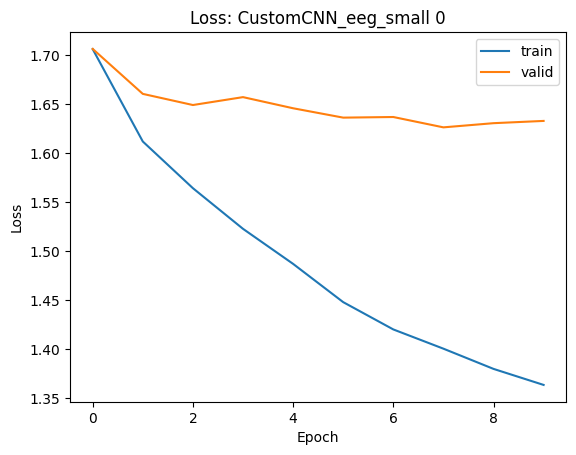

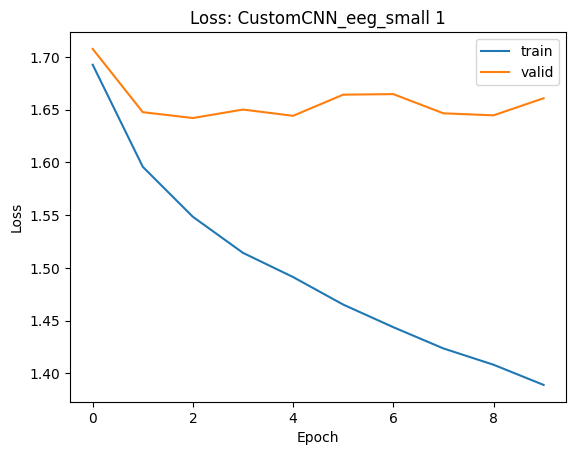

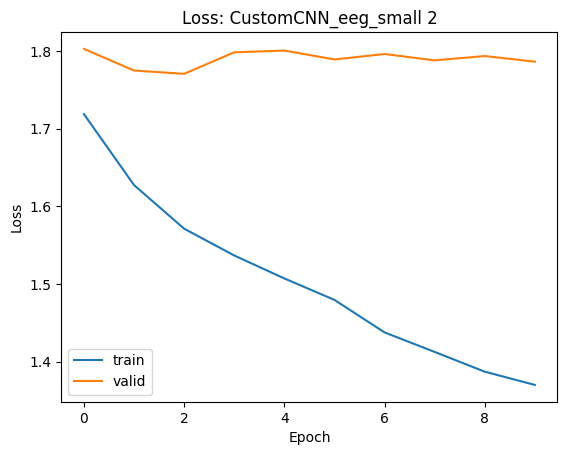

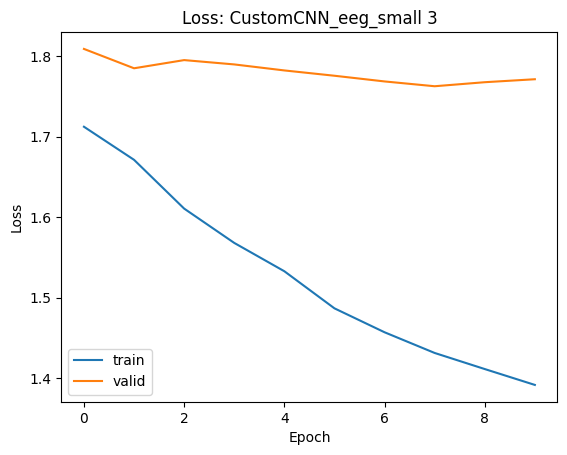

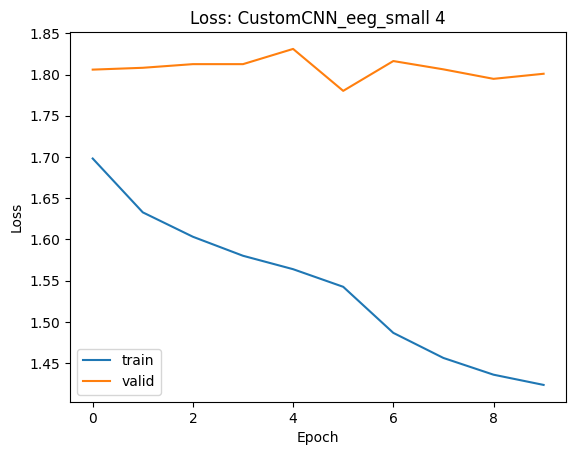

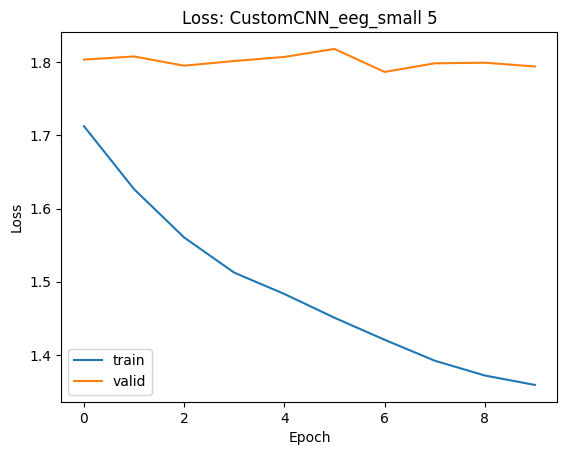

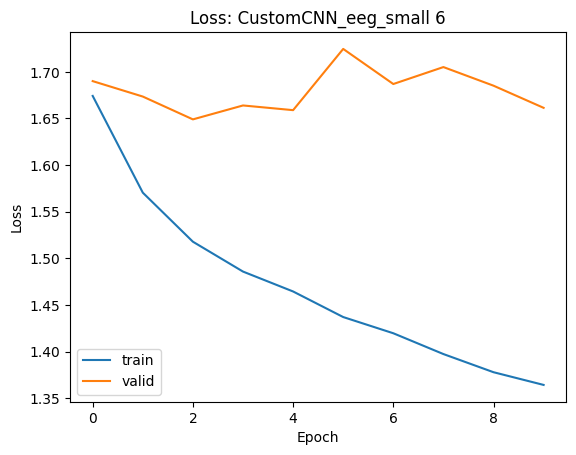

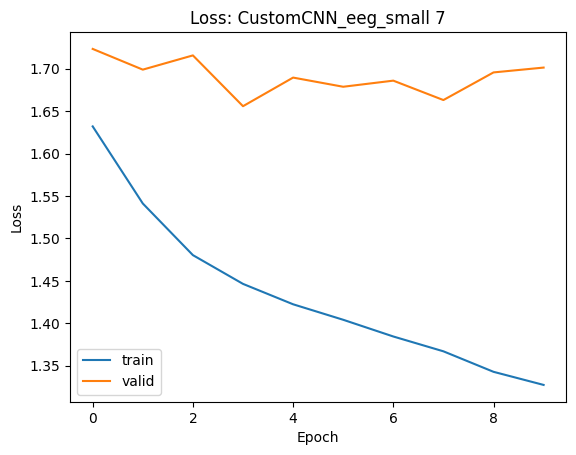

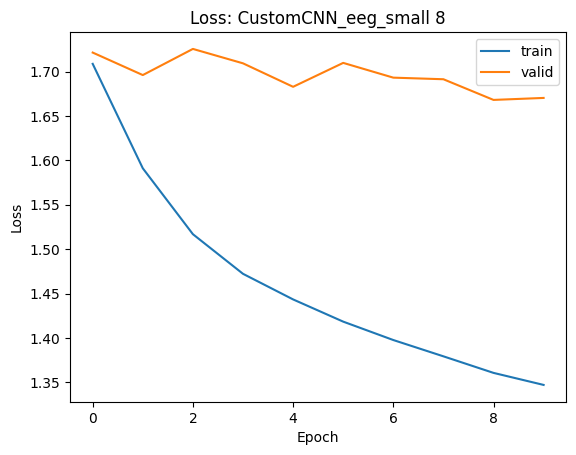

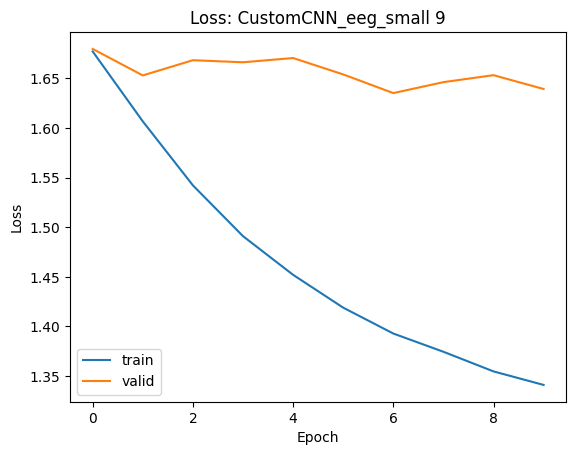

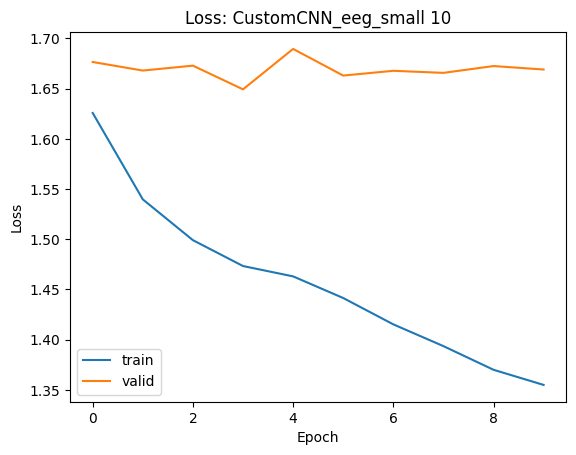

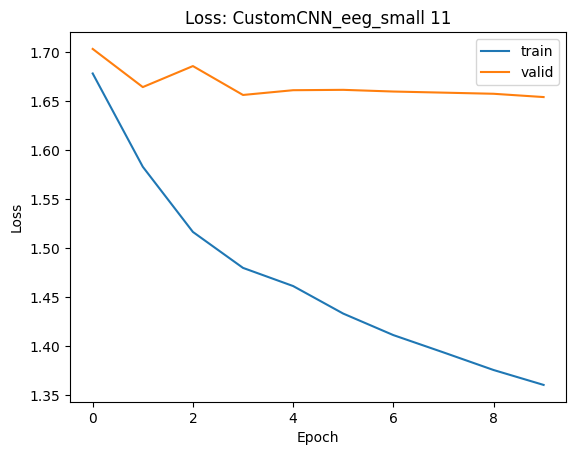

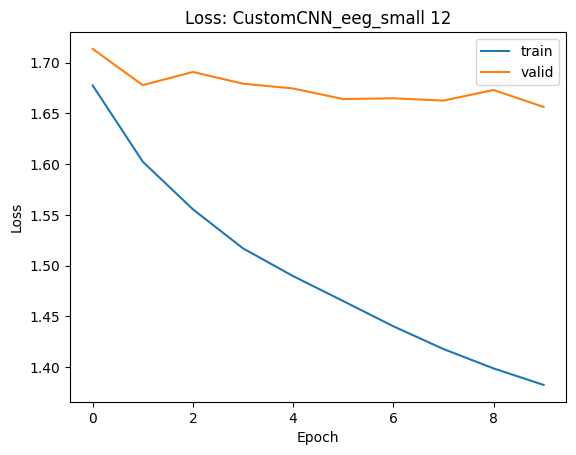

In [15]:
for index, file in enumerate(model_info_paths):
    with open(file, "r") as f:
        model_info = json.load(f)
    
    epochs = len(model_info["track_loss"])
    # plot "track_loss" and "track_loss_val"
    fig, ax = plt.subplots()
    ax.plot([i for i in range(epochs)], model_info["track_loss"], label="train")
    ax.plot([i for i in range(epochs)], model_info["track_loss_val"], label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss: {model_info['model_name']} {index}")
    ax.legend()

    plt.show()

### Inference with the trained model

In [16]:
with open(path_out + "split.json", "r") as f:
    split = json.load(f)
train_p = np.array(split["train"])
test_p = np.array(split["test"])

df = pd.read_csv(path_df + f"train.csv")

### Move validation data to the training data folder for inference on the full dataset

In [17]:
# # move all files from save_path + "valid_data" to save_path + "train"
# import shutil

# valid_files = glob.glob(save_path + "valid/*")
# for file in valid_files:
#     shutil.move(file, save_path + "train/")

### Track the performance of the model

In [37]:
df_results = pd.DataFrame(columns=["model name", "test accuracy", "test loss", "test loss baseline", "ensemble weight %"])
df_results['model name'] = [' '.join(m.split('\\')[-1].split('.')[0].split('_')[1:]) for m in model_info_paths]

### Inference and evaluation on the test set

Running inference for CustomCNN_eeg_small_0 on test set...


  0%|          | 0/345 [00:00<?, ?it/s]

 82%|████████▏ | 282/345 [00:12<00:02, 21.88it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.25it/s]


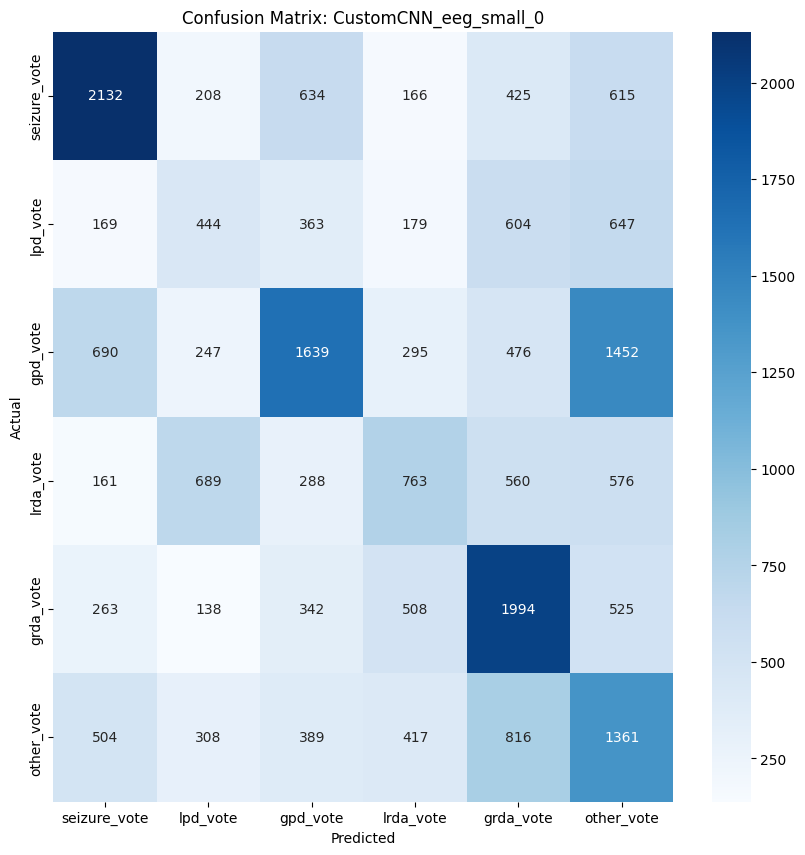

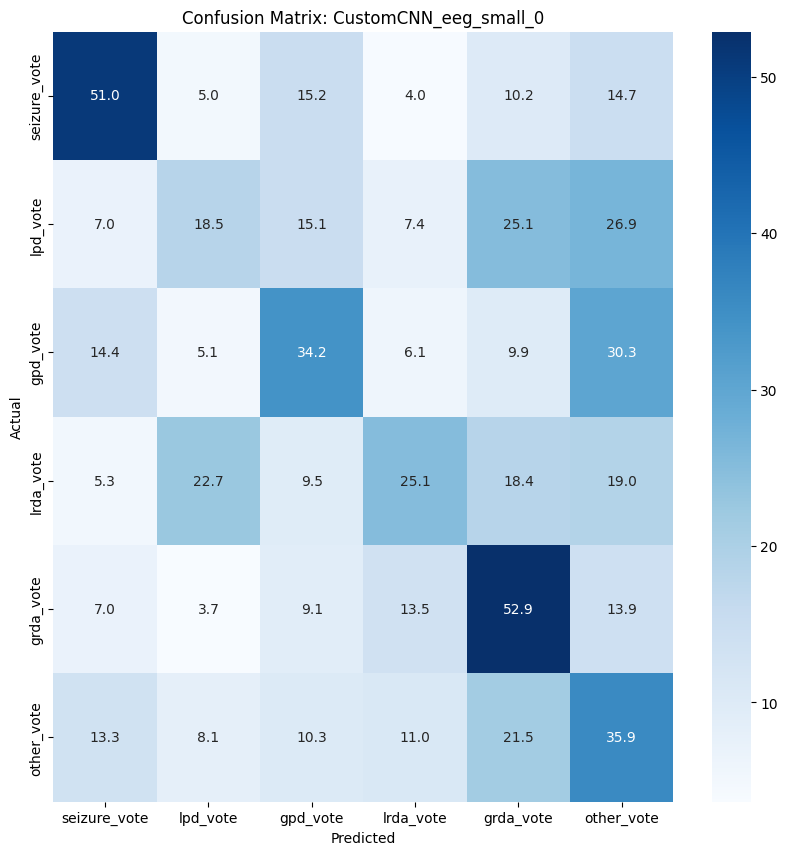

Accuracy: 37.89966798562787
Test Loss: 7.229555790680785
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_0 on train set...


 15%|█▌        | 161/1070 [00:06<00:38, 23.90it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:22, 24.53it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 22.96it/s]

Nan in output


100%|██████████| 1070/1070 [00:45<00:00, 23.50it/s]


Running inference for CustomCNN_eeg_small_1 on test set...


 82%|████████▏ | 284/345 [00:12<00:02, 22.51it/s]

Nan in output


100%|██████████| 345/345 [00:15<00:00, 22.74it/s]


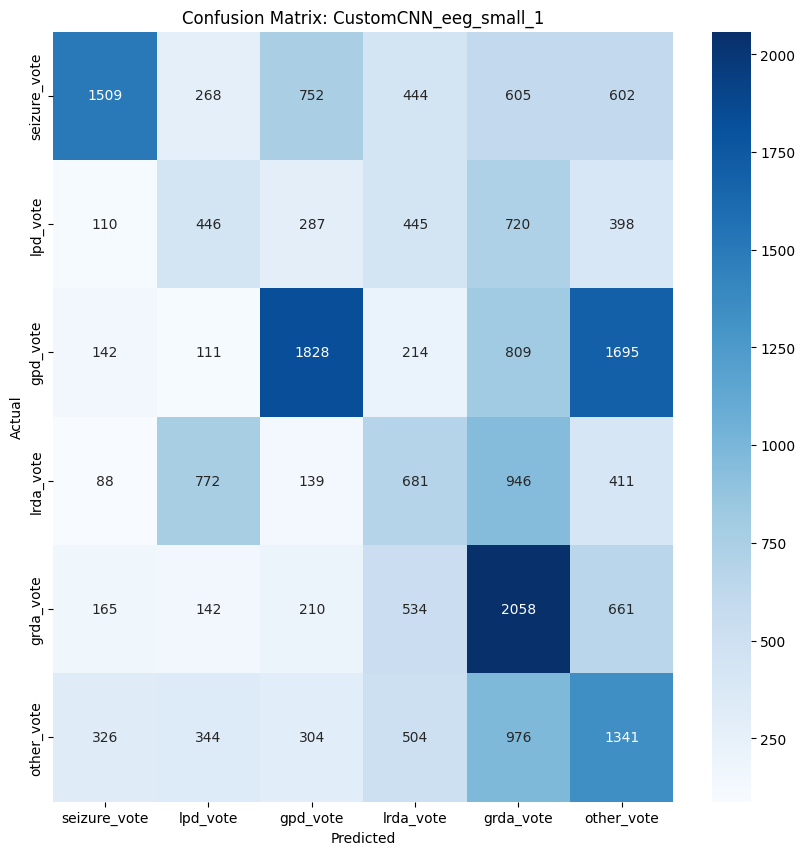

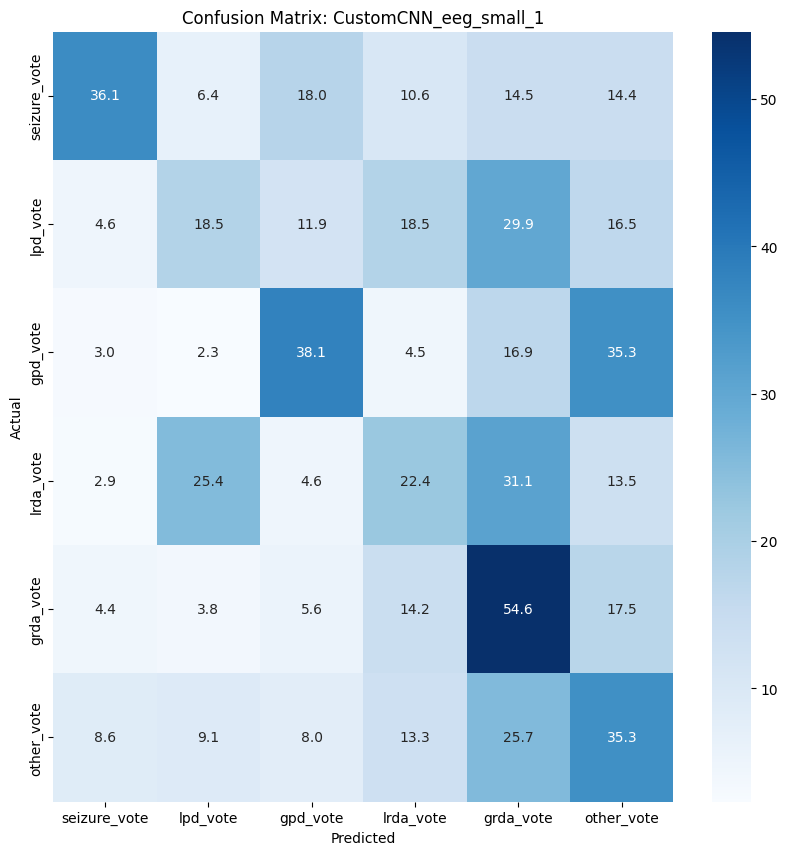

Accuracy: 35.76204120616728
Test Loss: 5.420054604126097
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_1 on train set...


 15%|█▌        | 162/1070 [00:07<00:41, 21.95it/s]

Nan in output


 49%|████▊     | 519/1070 [00:22<00:22, 24.46it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:44<00:01, 24.02it/s]

Nan in output


100%|██████████| 1070/1070 [00:45<00:00, 23.36it/s]


Running inference for CustomCNN_eeg_small_2 on test set...


 83%|████████▎ | 285/345 [00:12<00:02, 23.37it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.66it/s]


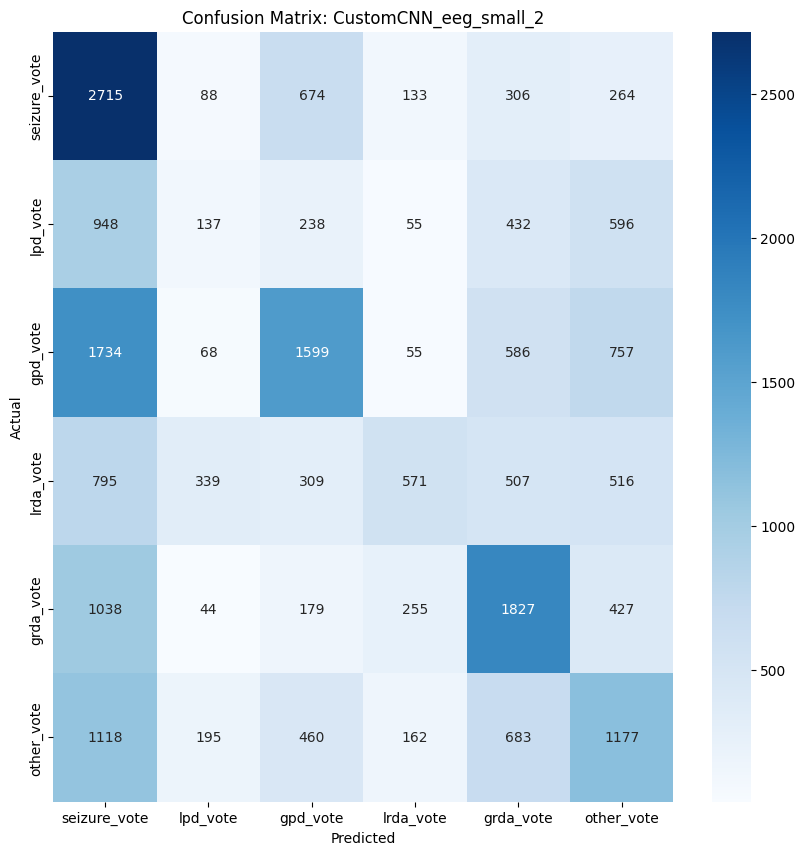

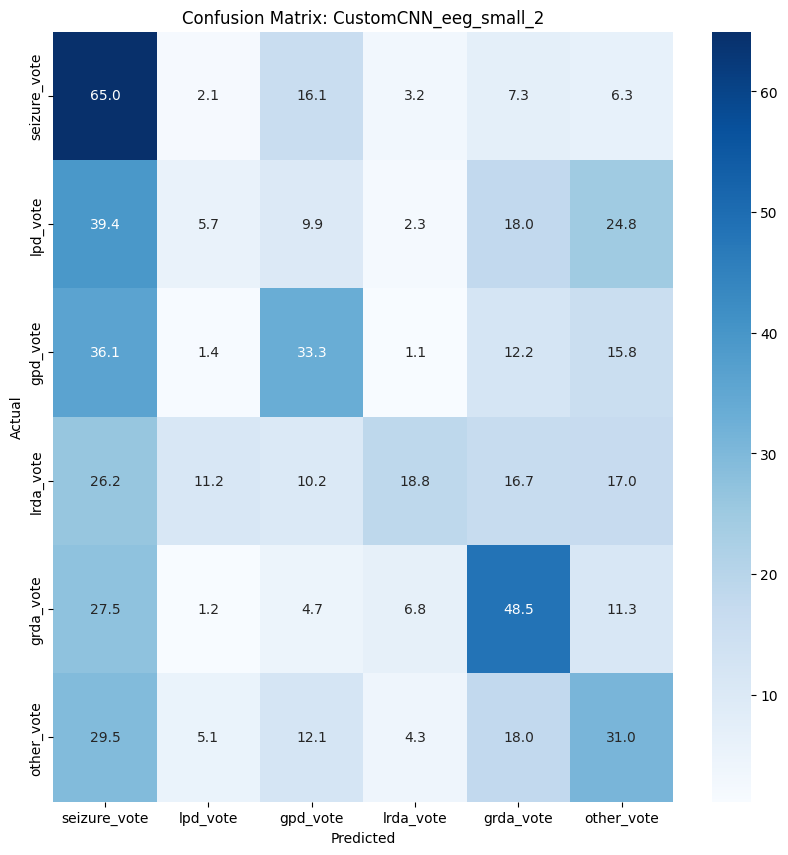

Accuracy: 36.50338836585255
Test Loss: 5.857148808708717
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_2 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.51it/s]

Nan in output


 48%|████▊     | 516/1070 [00:22<00:24, 22.97it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 24.76it/s]

Nan in output


100%|██████████| 1070/1070 [00:45<00:00, 23.50it/s]


Running inference for CustomCNN_eeg_small_3 on test set...


 83%|████████▎ | 285/345 [00:11<00:02, 24.07it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.99it/s]


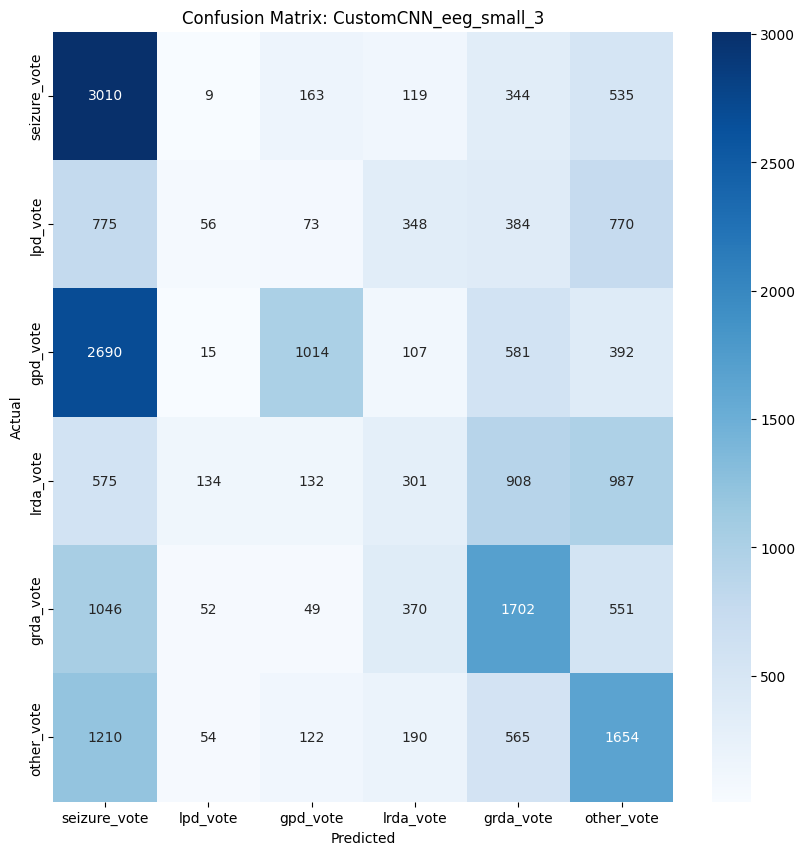

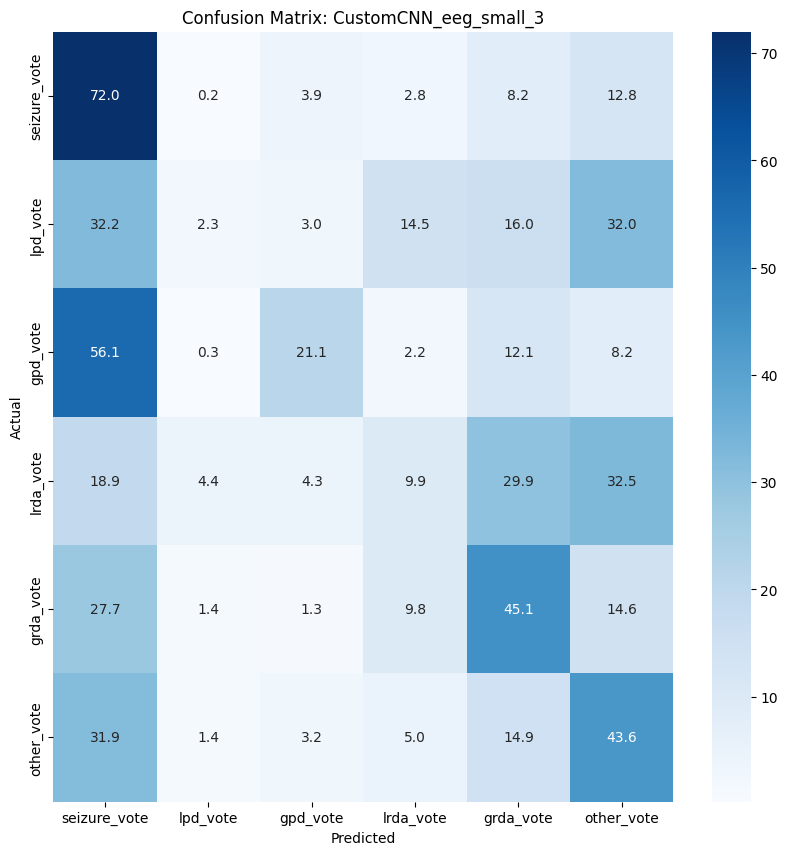

Accuracy: 35.188975303588485
Test Loss: 8.338441870760086
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_3 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.02it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:22, 25.05it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 22.76it/s]

Nan in output


100%|██████████| 1070/1070 [00:45<00:00, 23.69it/s]


Running inference for CustomCNN_eeg_small_4 on test set...


 82%|████████▏ | 283/345 [00:13<00:03, 17.12it/s]

Nan in output


100%|██████████| 345/345 [00:16<00:00, 20.70it/s]


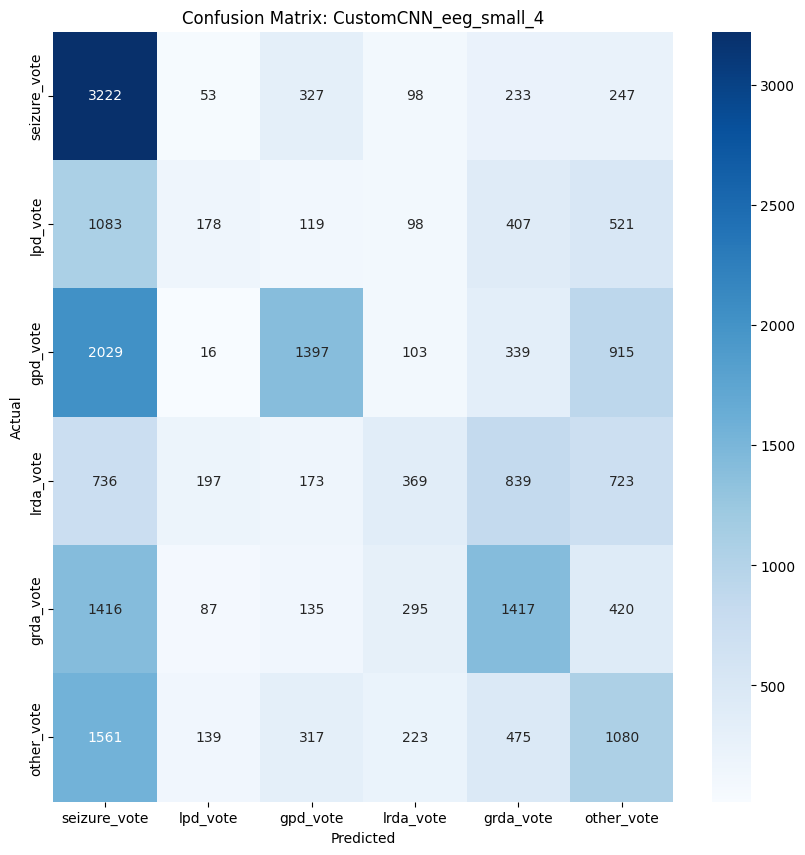

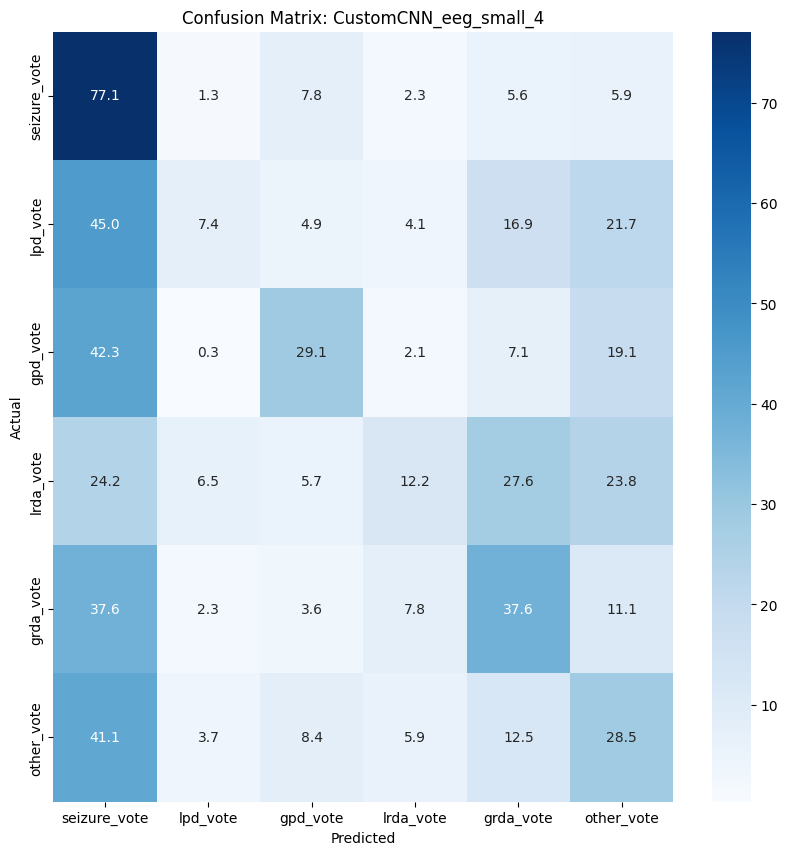

Accuracy: 34.85241278937554
Test Loss: 11.453559226767961
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_4 on train set...


 15%|█▍        | 160/1070 [00:07<00:41, 22.06it/s]

Nan in output


 48%|████▊     | 518/1070 [00:24<00:24, 22.23it/s]

Nan in output


 97%|█████████▋| 1034/1070 [00:46<00:01, 24.11it/s]

Nan in output


100%|██████████| 1070/1070 [00:47<00:00, 22.34it/s]


Running inference for CustomCNN_eeg_small_5 on test set...


 82%|████████▏ | 284/345 [00:12<00:02, 21.10it/s]

Nan in output


100%|██████████| 345/345 [00:15<00:00, 22.62it/s]


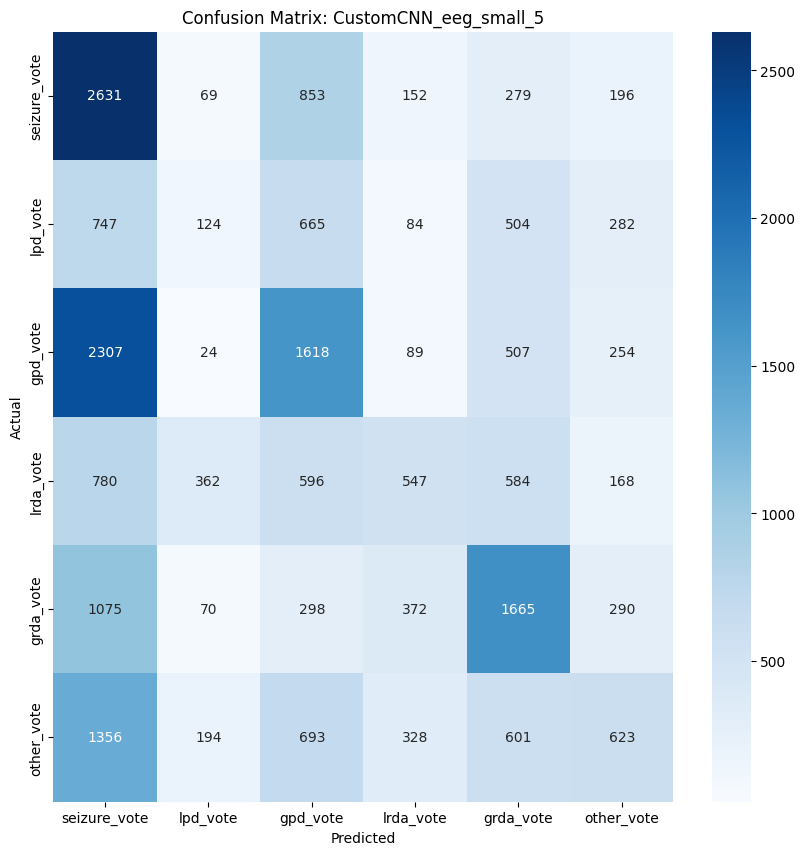

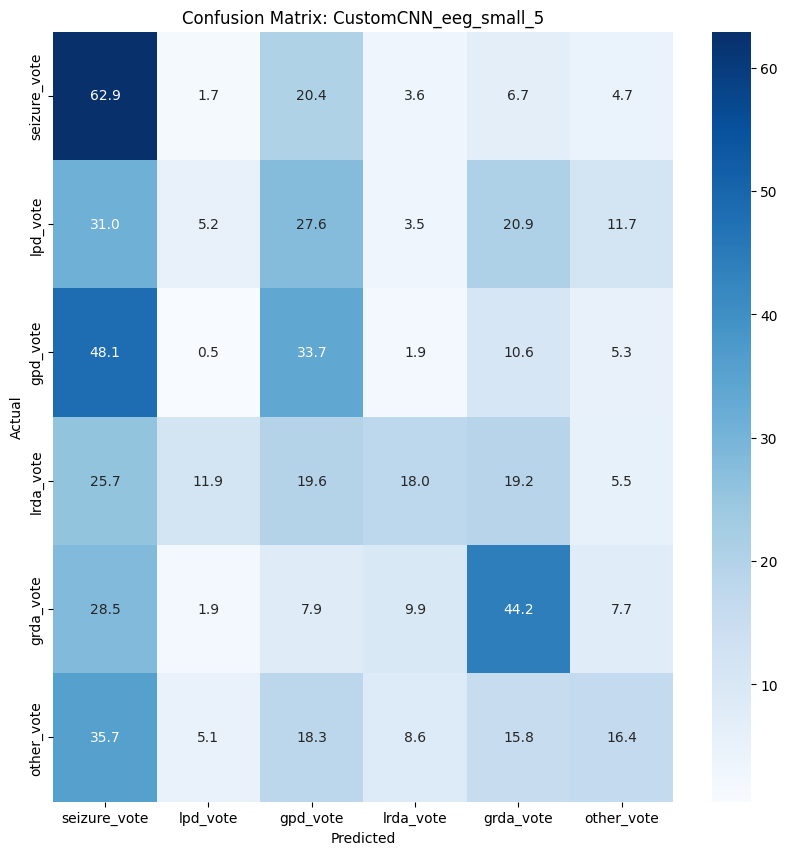

Accuracy: 32.78300814117433
Test Loss: 5.005065871965747
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_5 on train set...


 15%|█▌        | 162/1070 [00:07<00:37, 24.09it/s]

Nan in output


 49%|████▊     | 519/1070 [00:21<00:22, 25.00it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 24.13it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 23.98it/s]


Running inference for CustomCNN_eeg_small_6 on test set...


 82%|████████▏ | 282/345 [00:11<00:02, 24.32it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.88it/s]


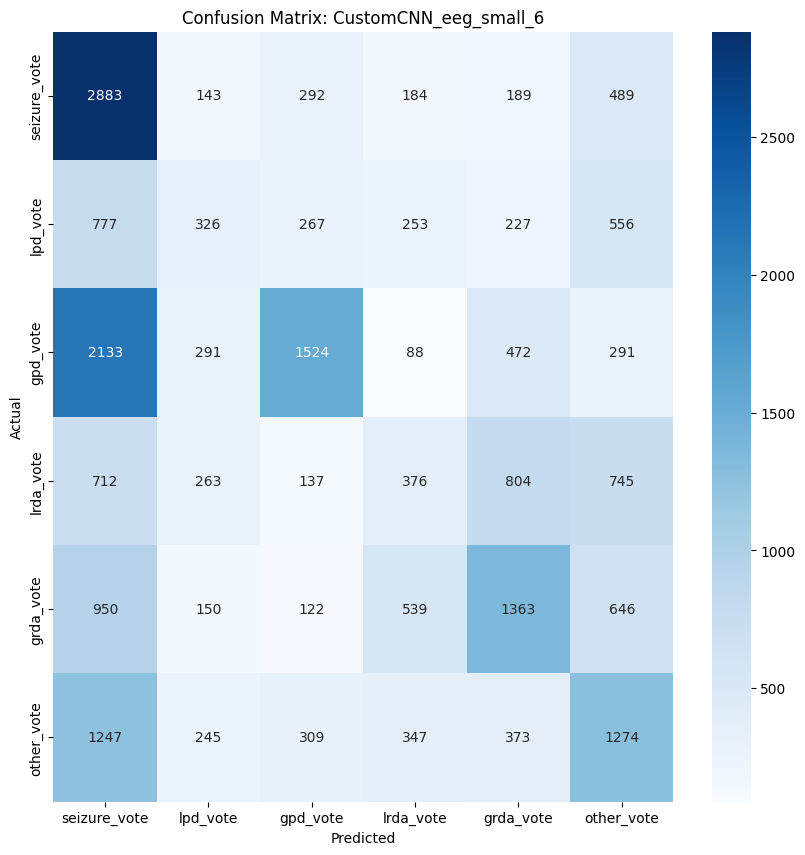

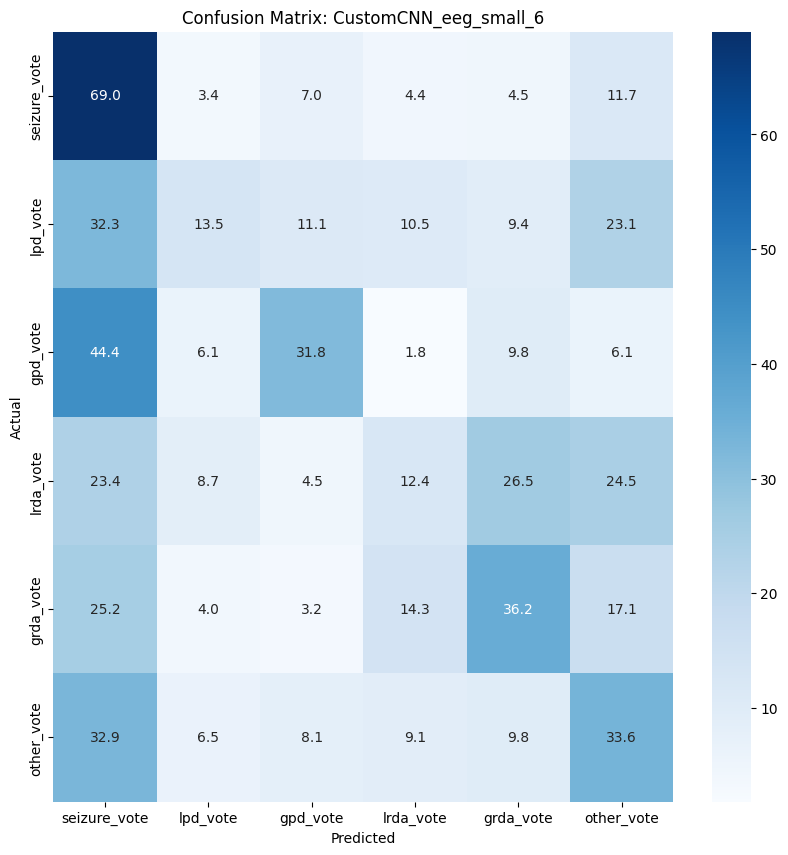

Accuracy: 35.22990858234411
Test Loss: 9.597141210596229
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_6 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.15it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:22, 24.32it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 24.85it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 23.99it/s]


Running inference for CustomCNN_eeg_small_7 on test set...


 82%|████████▏ | 284/345 [00:11<00:02, 25.16it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 24.39it/s]


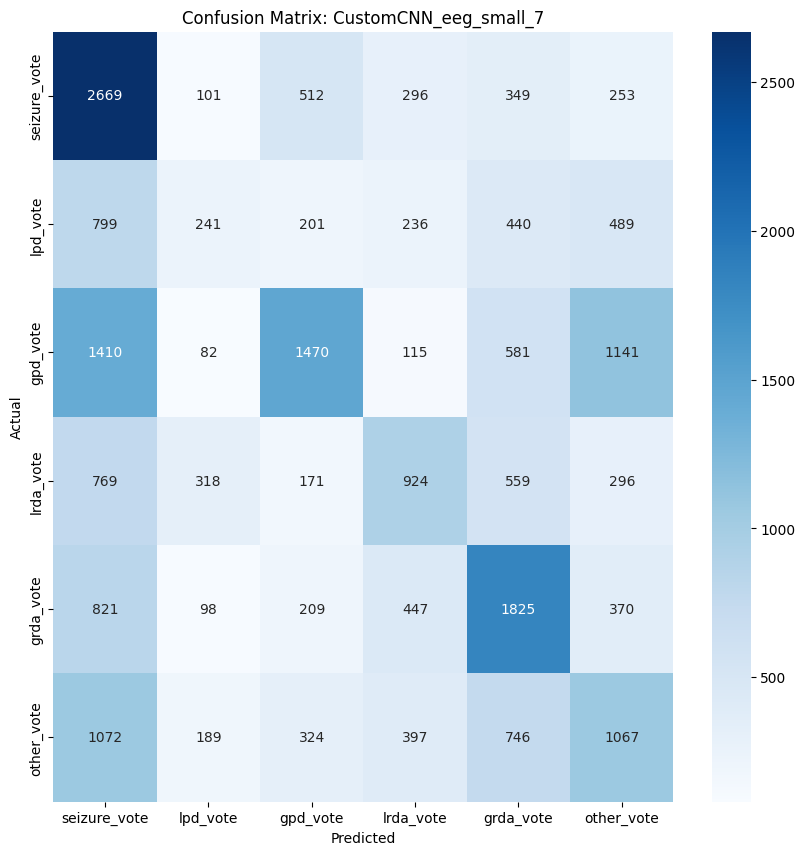

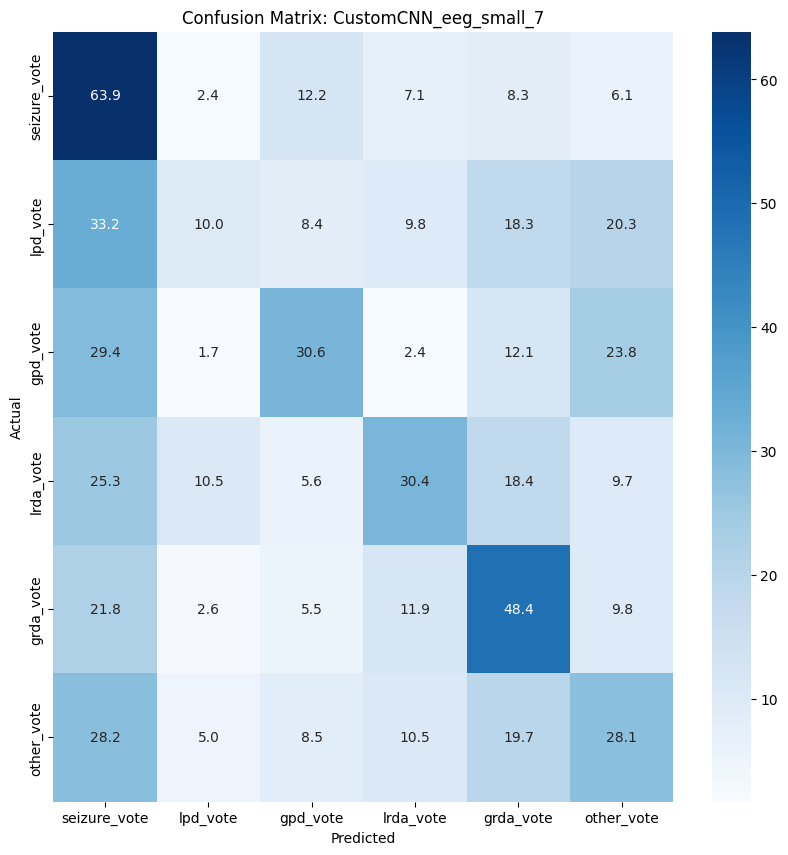

Accuracy: 37.27657252012553
Test Loss: 9.298798316959726
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_7 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.53it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:22, 24.26it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:42<00:01, 24.65it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 24.32it/s]


Running inference for CustomCNN_eeg_small_8 on test set...


 82%|████████▏ | 282/345 [00:11<00:02, 24.90it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 24.23it/s]


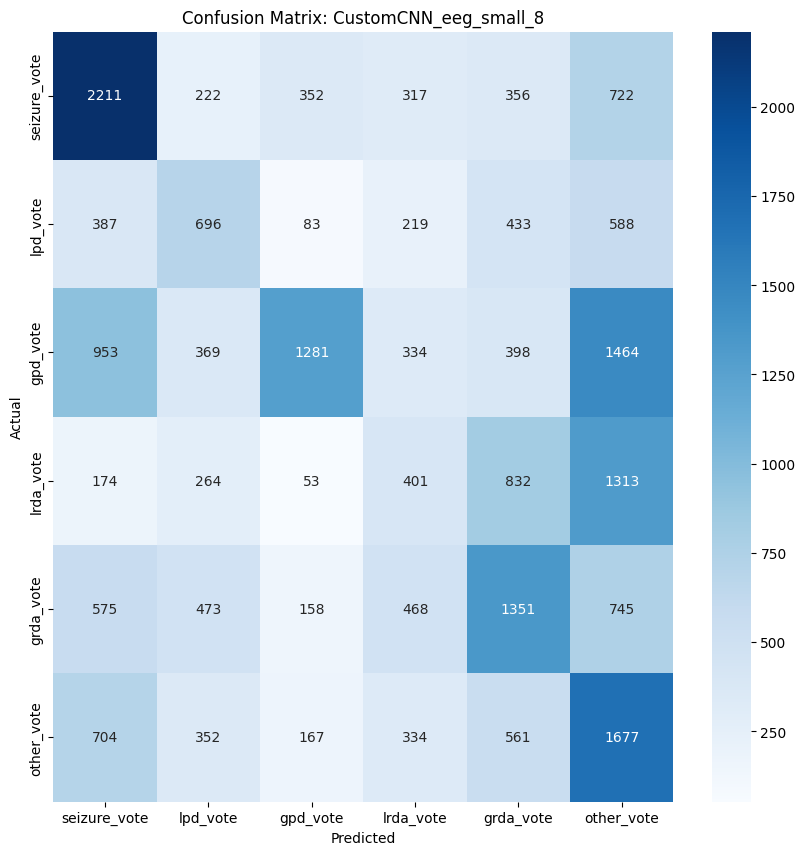

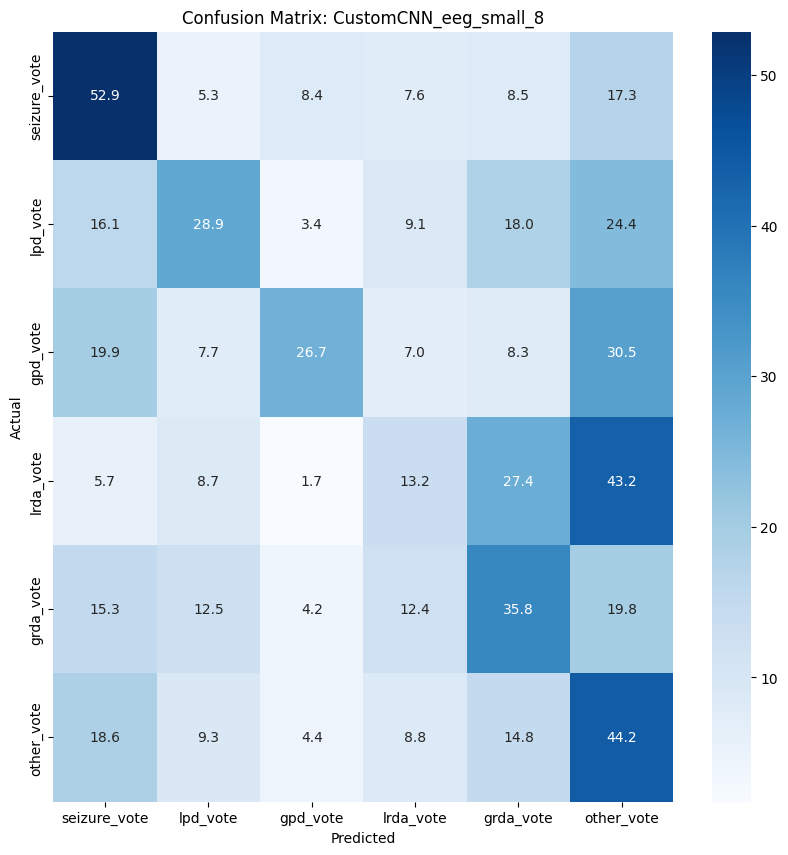

Accuracy: 34.64319825351344
Test Loss: 11.412048812305859
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_8 on train set...


 15%|█▌        | 162/1070 [00:06<00:35, 25.33it/s]

Nan in output


 49%|████▊     | 519/1070 [00:21<00:22, 24.50it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:42<00:01, 23.54it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 24.07it/s]


Running inference for CustomCNN_eeg_small_9 on test set...


 82%|████████▏ | 284/345 [00:11<00:02, 24.01it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.80it/s]


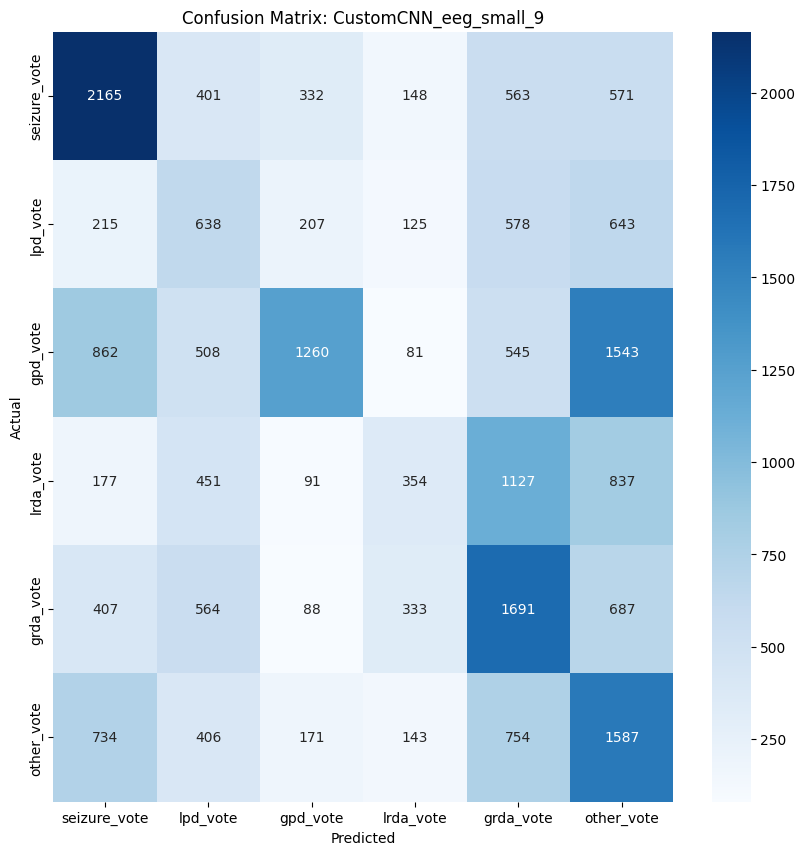

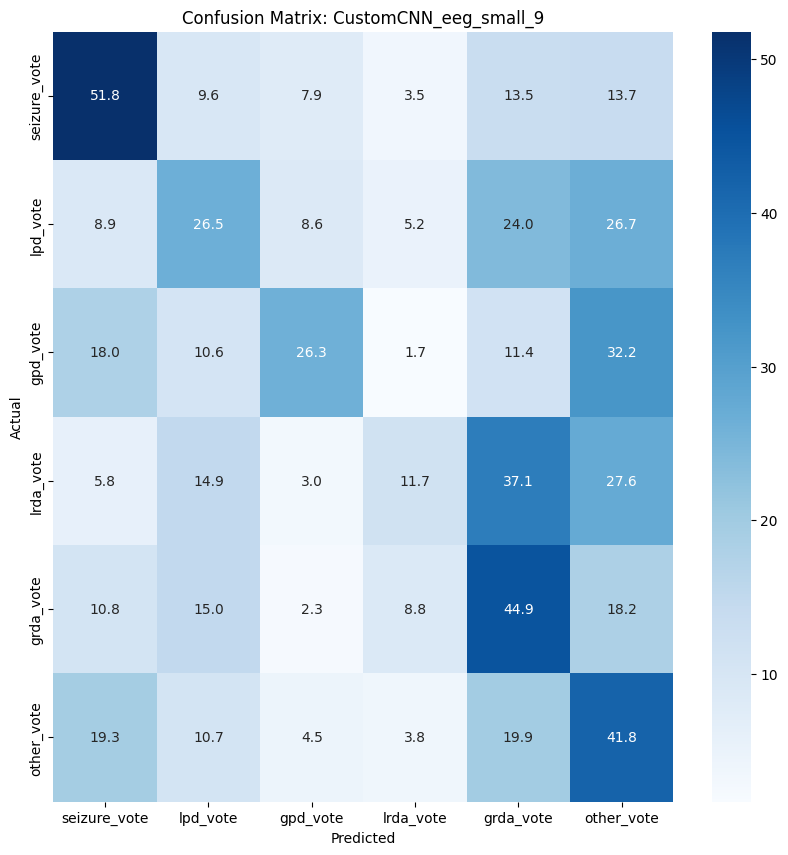

Accuracy: 34.99795333606222
Test Loss: 11.67905698643001
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_9 on train set...


 15%|█▌        | 163/1070 [00:07<00:37, 24.37it/s]

Nan in output


 48%|████▊     | 517/1070 [00:22<00:22, 24.95it/s]

Nan in output


 97%|█████████▋| 1033/1070 [00:43<00:01, 25.16it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 23.89it/s]


Running inference for CustomCNN_eeg_small_10 on test set...


 83%|████████▎ | 285/345 [00:12<00:02, 23.03it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 23.58it/s]


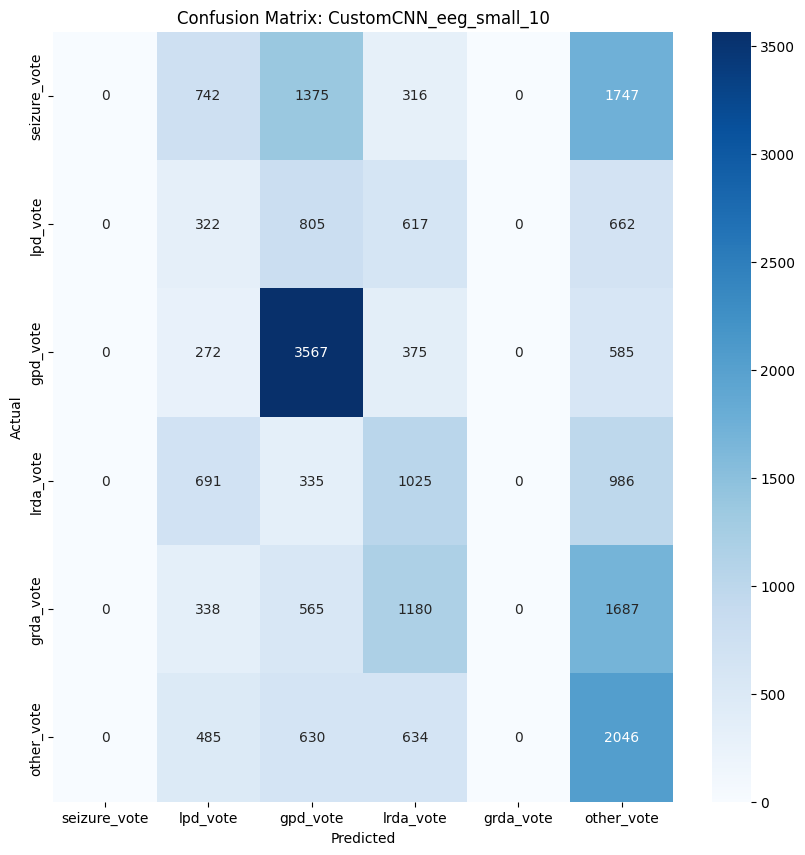

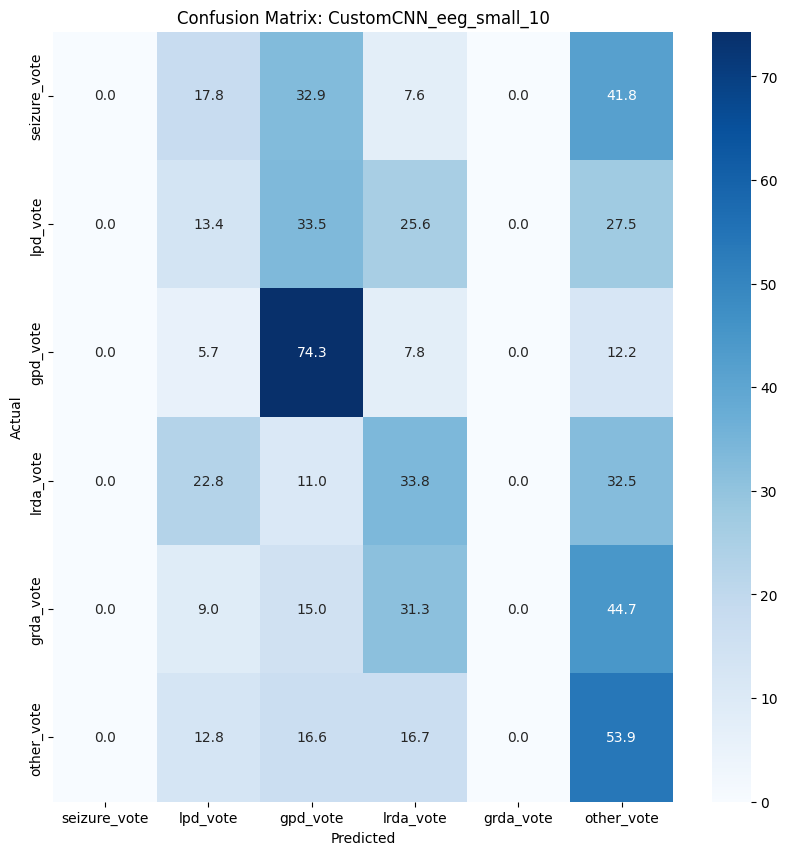

Accuracy: 31.65506890435257
Test Loss: 5.638089778204313
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_10 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.45it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:22, 24.70it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 24.81it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 23.99it/s]


Running inference for CustomCNN_eeg_small_11 on test set...


 82%|████████▏ | 282/345 [00:11<00:02, 24.86it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 24.13it/s]


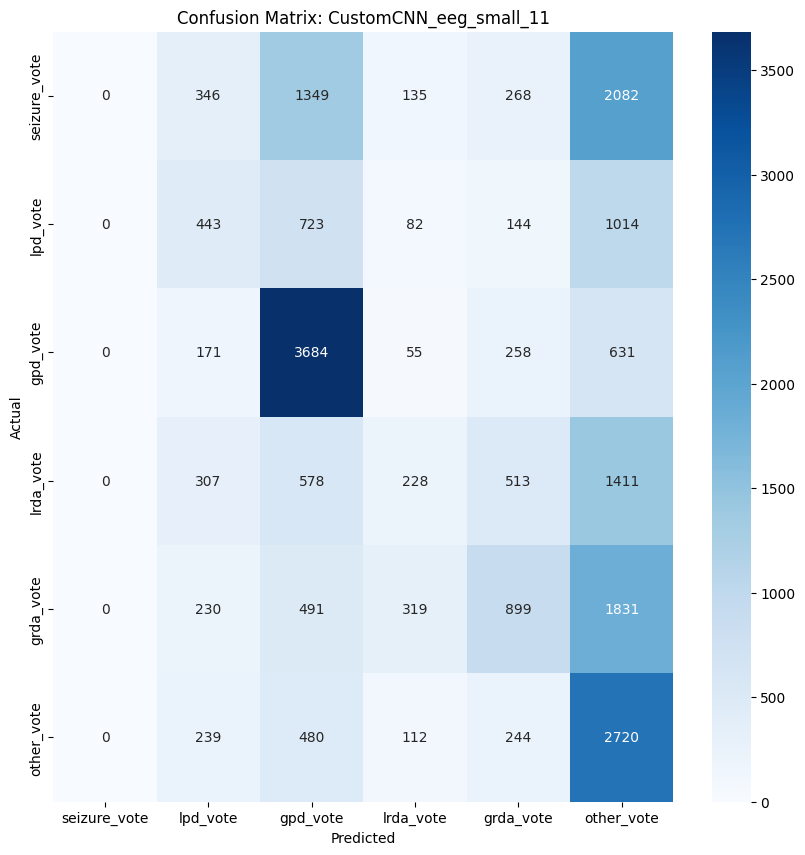

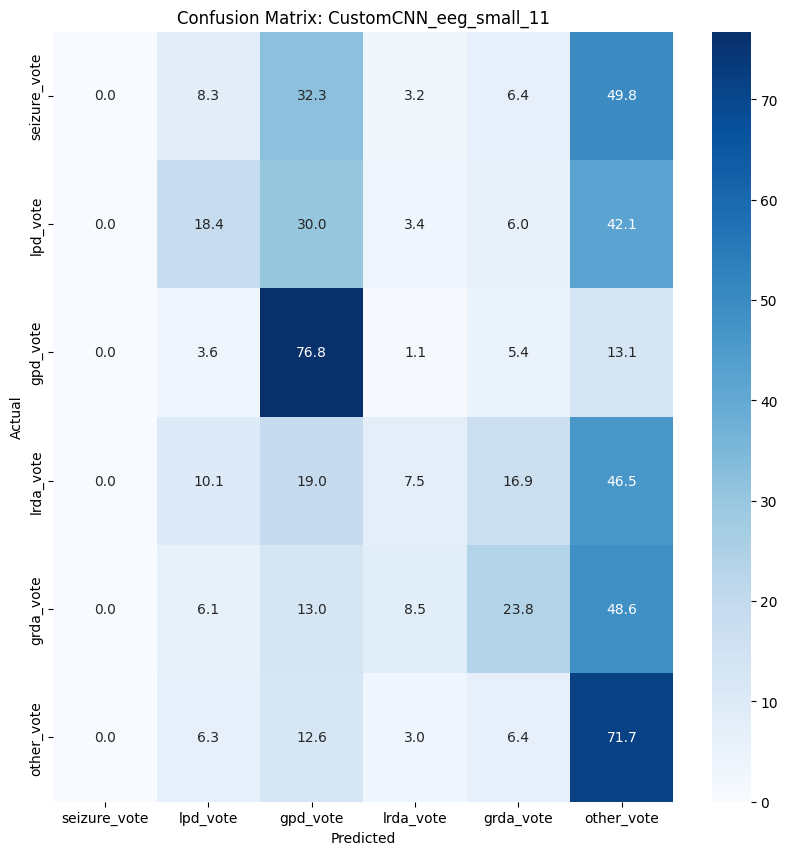

Accuracy: 36.2668849774867
Test Loss: 9.499483949989406
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_11 on train set...


 15%|█▌        | 162/1070 [00:06<00:37, 24.23it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:23, 24.01it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:43<00:01, 24.90it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 23.90it/s]


Running inference for CustomCNN_eeg_small_12 on test set...


 82%|████████▏ | 282/345 [00:11<00:02, 24.31it/s]

Nan in output


100%|██████████| 345/345 [00:14<00:00, 24.48it/s]


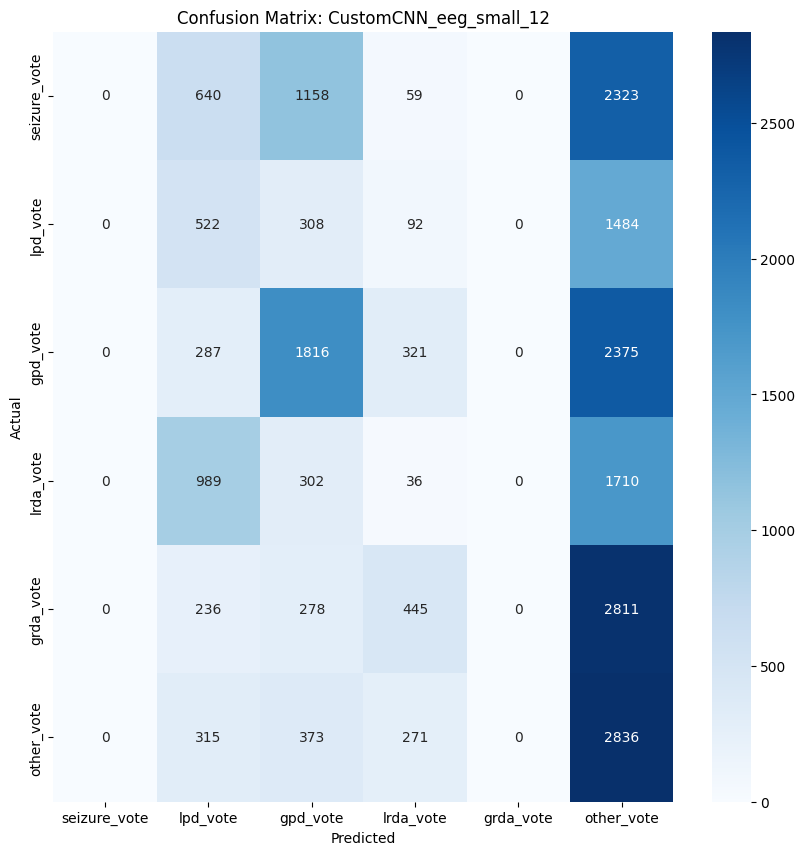

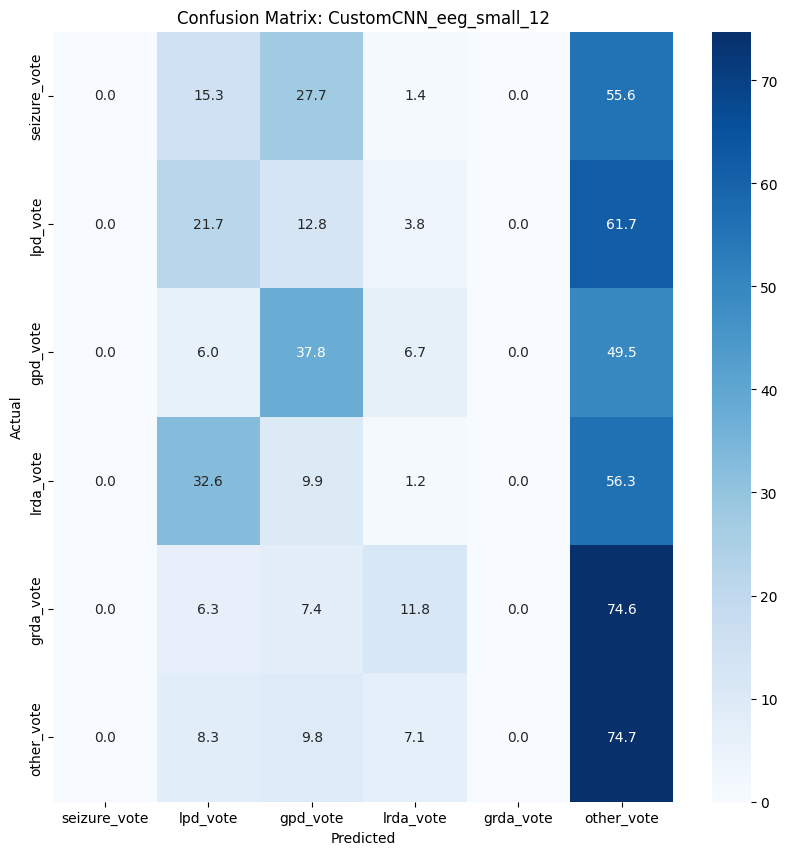

Accuracy: 23.69582025742484
Test Loss: 13.73842390227608
Test Loss Baseline: 1.0842595902639767
Running inference for CustomCNN_eeg_small_12 on train set...


 15%|█▌        | 162/1070 [00:06<00:36, 24.93it/s]

Nan in output


 48%|████▊     | 516/1070 [00:21<00:23, 23.93it/s]

Nan in output


 96%|█████████▋| 1032/1070 [00:42<00:01, 24.91it/s]

Nan in output


100%|██████████| 1070/1070 [00:44<00:00, 24.06it/s]


In [77]:
for index in range(len(model_info_paths)):
    model_info_path = model_info_paths[index]

    #load model info from json
    with open(model_info_path, "r") as f:
        model_info = json.load(f)

    date_type = model_info["data_type"]
    input_shape = model_info["input_shape"]
    model_name = model_info["model_name"]
    loss_type = model_info["configs"]["loss_type"]
    if model_name == "CustomCNN_eeg_small":
        transform = (lambda batch_size, x: x[:, 0, :, :].reshape(batch_size, *input_shape),)
    else:
        transform = tuple()


    N_samples = len(df[df["patient_id"].isin(test_p)])
    N_samples = np.ceil(N_samples / batch_size).astype(int)
    test_data = CustomDatasetNPY(
        save_path + f"test_{data_type}/",
        [str(i) for i in range(N_samples)],
        transform=transform,
    )
    test_loader = DataLoader(
        test_data, batch_size=1, shuffle=False, num_workers=num_workers
    )

    path_model = path_out + f"model_{model_name}_{index}.pt"

    print(f"Running inference for {model_name}_{index} on test set...")
    accuracy, test_loss, test_loss_baseline, cm, cm_p, predictions, labels = (
        run_inference(model_name, path_model, test_loader, input_shape, is_test=test, loss_type=loss_type)
    )

    #####

    # save results

    loss_dict = {
        "test_loss_kl": test_loss,
        "test_loss_baseline_kl": test_loss_baseline,
        "test_accuracy": accuracy,
    }

    # save predictions and labels as npy
    np.save(path_out + f"test_predictions_{model_name}_{index}.npy", predictions)
    np.save(path_out + f"test_labels_{model_name}_{index}.npy", labels)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
    plt.yticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}_{index}")

    # plt.savefig(path_out + f"cm_{model_name}_{index}.png")

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_p * 100, annot=True, fmt=".1f", cmap="Blues")
    plt.xticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
    plt.yticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}_{index}")

    # plt.savefig(path_out + f"cm_probs_{model_name}_{index}.png")

    plt.show()

    # print accuracy, test_loss, test_loss_baseline
    print(f"Accuracy: {accuracy}")
    print(f"Test Loss: {test_loss}")
    print(f"Test Loss Baseline: {test_loss_baseline}")

    df_results.loc[index, "test accuracy"] = accuracy
    df_results.loc[index, "test loss"] = test_loss
    df_results.loc[index, "test loss baseline"] = test_loss_baseline


    # Inference on training set
    N_samples = len(os.listdir(save_path + f"train_{data_type}/"))//2
    train_data = CustomDatasetNPY(
        save_path + f"train_{data_type}/",
        [str(i) for i in range(N_samples)],
        transform=transform,
    )

    train_loader = DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=num_workers
    )

    print(f"Running inference for {model_name}_{index} on train set...")
    _, _, _, _, _, predictions, labels = (
        run_inference(model_name, path_model, train_loader, input_shape, is_test=test, loss_type=loss_type)
    )

    # save predictions and labels as npy
    np.save(path_out + f"train_predictions_{model_name}_{index}.npy", predictions)
    np.save(path_out + f"train_labels_{model_name}_{index}.npy", labels)


    # save loss_dict to json
    with open(path_out + f"eval_{model_name}_{index}.json", "w") as f:
        json.dump(loss_dict, f)

### Ensemble model

In [78]:
data_files = os.listdir(path_out)
data_features = [f for f in data_files if f.startswith('train_predictions')]
data_votes = [f for f in data_files if f.startswith('train_labels')]

N_items = len(data_features)

print("Number of models", N_items)

test_data_features = [f for f in data_files if f.startswith('test_predictions')]
test_data_votes = [f for f in data_files if f.startswith('test_labels')]

N_test_items = len(test_data_features)

print("Number of test models", N_test_items)

Number of models 13
Number of test models 13


In [79]:
# load all data_features into a single numpy array
X = []
Y = []
rows = []
for i in range(N_items):

    X_tmp = np.load(path_out+data_features[i])
    Y_tmp = np.load(path_out+data_votes[i])
    # if axis = -1 contains a nan then drop that row
    for r in np.where(np.isnan(X_tmp))[0]:
        rows.append(r)
rows = np.unique(rows)

for i in range(N_items):
    # exclude rows with nan
    X_tmp = np.load(path_out+data_features[i])
    Y_tmp = np.load(path_out+data_votes[i])
    X_tmp = np.delete(X_tmp, rows, axis = 0)
    X_tmp = X_tmp.reshape(1, *X_tmp.shape)
    Y_tmp = np.delete(Y_tmp, rows, axis = 0)
    Y_tmp = Y_tmp.reshape(1, *Y_tmp.shape)
    

    X.append(X_tmp)
    Y.append(Y_tmp)

X = np.vstack(X)
X= np.exp(X)
Y = np.vstack(Y)
Y = Y[0,:,:].reshape(1, *Y.shape[1:])

N_samples = X.shape[1]

In [80]:
# kl divergence taking into account zeros
def kl(p, q):
    p = np.maximum(p, 1e-12)
    q = np.maximum(q, 1e-12)
    return np.mean(p * np.log(p / q))

def mean_KL(Y_p, X_1, N_samples, N_classes):
    # apply kl divergence to all time points
    KL = np.zeros((N_samples, N_classes))
    for i in range(N_samples):
        KL[i] = kl(Y_p[0,i,:], X_1[i,:])

    KL = np.sum(KL, axis=1)

    return np.mean(KL)

Initial mean KL div: 1.22
1.195646723888669
1.1905860445008967
1.1869219823721548
1.184214029340672
1.1821862412993898
1.1806541583013939
1.1794891804171257
1.1785990754297124
1.1779163870078562
1.1773910065292428
1.1769855758677346
1.176671875762899
1.176428510059781
1.1762392053537
1.176091548922333
1.1759760481167432
1.1758854314914464
1.1758141241836775
1.1757578355043483
1.1757132598695927
1.1756778454402117
1.1756496179232978
1.1756270462260754
1.1756089399142877
1.1755943708657328
1.1755826133445761
1.1755730981093684
1.175565377219351
1.1755590970021899
1.1755539772530437
1.1755497951961231
1.1755463730904763
1.1755435686282638
1.1755412674763441
1.175539377465956
1.1755378240523668
1.1755365467553665
1.175535496359231
1.1755346327023588
1.1755339229261048
1.1755333400823174
1.1755328620220002
1.175532470505081
1.1755321504846656
1.1755318895295346
1.1755316773565323
1.17553150545068
1.1755313667555471
1.1755312554201254
1.1755311665912964
1.1755310962432275
1.1755310410367787


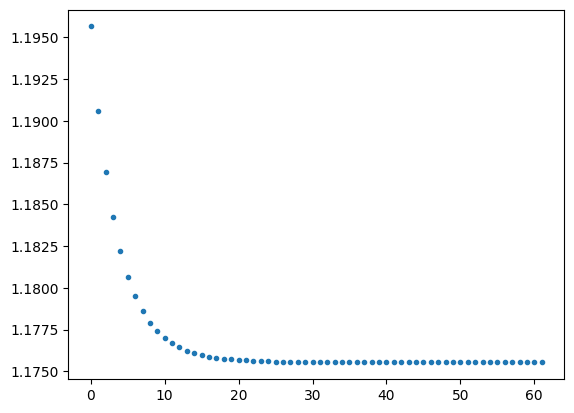

In [148]:
Y_p = Y/np.sum(Y, axis=2).reshape(1,N_samples,1)

# theta = [1/N_items]*N_items
# randomly initialize theta
theta = np.random.rand(N_items)+1e-12
theta = theta/np.sum(theta)
theta_0 = np.array(theta).reshape(N_items,1,1)
X_0 = np.sum(theta_0*X, axis=0) 
X_0 = X_0/X_0.sum(axis=-1).reshape(N_samples, 1)

print(f"Initial mean KL div: {mean_KL(Y_p, X_0, N_samples, N_classes):.2f}")

KL = []
lr = 0.01
for _ in range(100):

    grad = (np.sum(np.sum((Y_p*X)/np.sum(theta_0*X, axis=0).reshape(1,N_samples,6), axis = -1), axis = -1) -1)/N_samples
    # print(np.mean(theta_0), np.mean(grad)*lr)
    theta_new = (theta_0.reshape(N_items) + lr*grad).reshape(N_items,1,1)
    theta_new = theta_new/np.sum(theta_new)
    # print(theta_new[:,0,0])
    
    X_0 = np.sum(theta_new*X, axis=0) 
    X_0 = X_0/X_0.sum(axis=-1).reshape(N_samples, 1)
    KL.append(mean_KL(Y_p, X_0, N_samples, N_classes))
    print(KL[-1])
    if len(KL)>1:
        if KL[-1]>KL[-2]:
            break
            pass
        else:
            theta_best = theta_new
    
    theta_0 = theta_new

    # break

print(f"Final mean KL div: {mean_KL(Y_p, X_0, N_samples, N_classes):.2f}")
# plot the KL divergence
plt.plot(KL, '.')

In [160]:
df_results['ensemble weight %'] = list(theta_best[:,0,0]*100)+[None]

In [150]:
# load all data_features into a single numpy array
X_test = []
Y_test = []
rows = []
for i in range(N_items):

    X_tmp = np.load(path_out+data_features[i])
    Y_tmp = np.load(path_out+data_votes[i])
    # if axis = -1 contains a nan then drop that row
    for r in np.where(np.isnan(X_tmp))[0]:
        rows.append(r)
rows = np.unique(rows)
# print(rows)

for i in range(N_test_items):
    # exclude rows with nan
    X_tmp = np.load(path_out+data_features[i])
    Y_tmp = np.load(path_out+data_votes[i])
    X_tmp = np.delete(X_tmp, rows, axis = 0)
    X_tmp = X_tmp.reshape(1, *X_tmp.shape)
    Y_tmp = np.delete(Y_tmp, rows, axis = 0)
    Y_tmp = Y_tmp.reshape(1, *Y_tmp.shape)
    

    X_test.append(X_tmp)
    Y_test.append(Y_tmp)

X_test = np.vstack(X_test)
X_test= np.exp(X_test)
Y_test = np.vstack(Y_test)
Y_test = Y[0,:,:].reshape(1, *Y_test.shape[1:])

N_test_samples = X_test.shape[1]

In [151]:
X_ensemble = np.sum(theta_best*X_test, axis=0)
X_ensemble = X_ensemble/X_ensemble.sum(axis=-1).reshape(N_test_samples, 1)
Y_p_test = Y_test/np.sum(Y_test, axis=2).reshape(1,N_test_samples,1)

KL_test = mean_KL(Y_p_test, X_ensemble, N_test_samples, N_classes)

print(f"Ensemble mean KL div: {KL_test:.2f}")

Ensemble mean KL div: 1.18


Accuracy: 68.99%


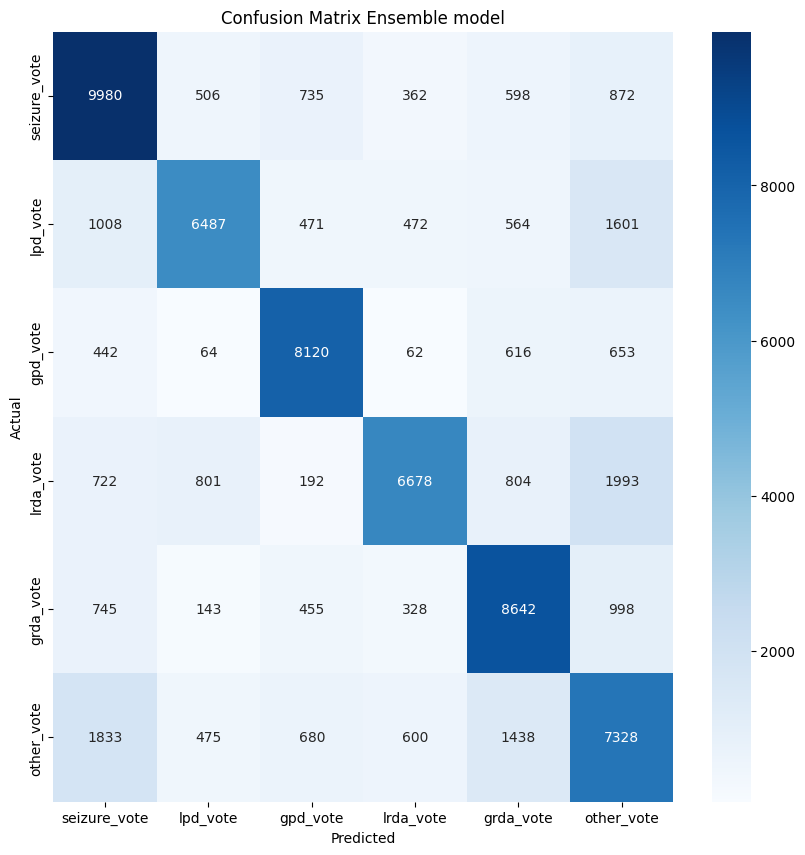

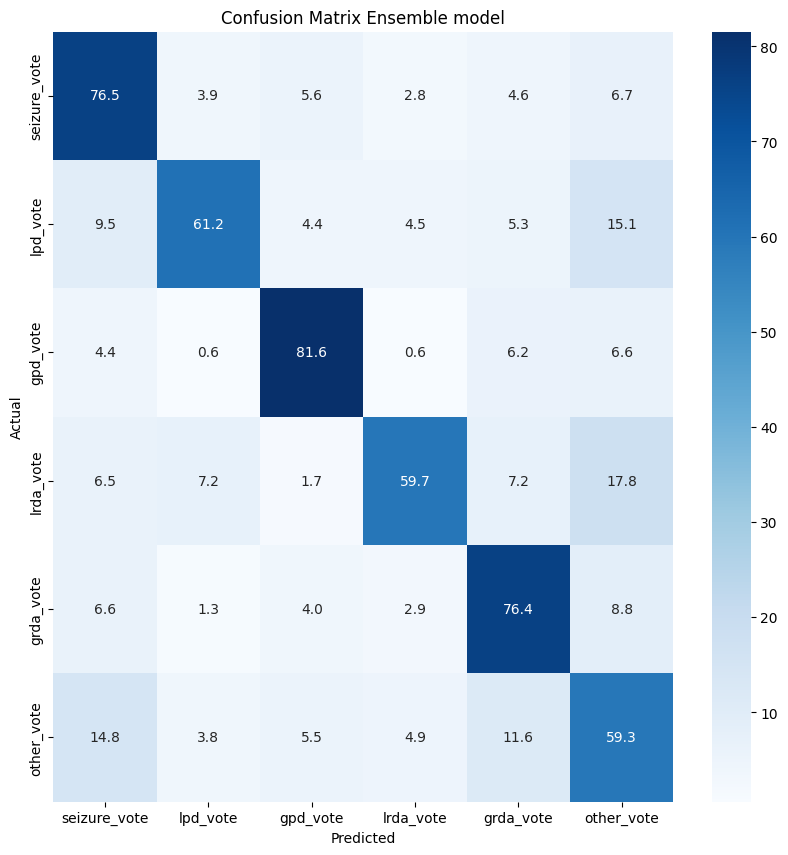

In [172]:
from sklearn.metrics import accuracy_score

y_test_class = np.argmax(Y_p_test, axis=2)[0,:]
predictions = np.argmax(X_ensemble, axis=1)

accuracy = accuracy_score(y_test_class, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = confusion_matrix(y_test_class, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
plt.yticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Ensemble model')
plt.show()

cm_p = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm_p*100, annot=True, fmt=".1f", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
plt.yticks(ticks=np.arange(6) + 0.5, labels=votes_cols)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Ensemble model')
plt.show()

### Summary

In [153]:
info_keys = ["min_votes", "augmentation","data_type","num_parameters","num_trainable_parameters","configs-label_smoothing","configs-loss_type"]
df_model_params = pd.DataFrame(columns=["model name"]+info_keys)

for index, file in enumerate(model_info_paths):
    with open(file, "r") as f:
        model_info = json.load(f)
    # collapse nested keys
    model_info["configs-label_smoothing"] = model_info["configs"]["label_smoothing"]
    model_info["configs-loss_type"] = model_info["configs"]["loss_type"]
    
    model_name = ' '.join(file.split('\\')[-1].split('.')[0].split('_')[1:])
    info = [model_name] + [model_info[key] for key in info_keys]
    df_model_params.loc[index] = info

In [157]:
df_results = df_results[['model name', 'test accuracy', 'test loss', 'test loss baseline',
       'ensemble weight']]

In [158]:
#add row to results
df_results.loc[len(df_results)-1] = ['ensemble', accuracy*100, KL_test, None, None]
# merge results with model params
df_results = df_results.merge(df_model_params, left_on='model name', right_on='model name', how='left')

In [173]:
# prretty print results
df_results_pp = df_results.replace({None: np.nan}).round(2)

df_results_pp.sort_values(by='test accuracy', ascending=False)

,model name,test accuracy,test loss,test loss baseline,ensemble weight %,min_votes,augmentation,data_type,num_parameters,num_trainable_parameters,configs-label_smoothing,configs-loss_type
13,ensemble,68.99,1.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,CustomCNN eeg small 0,37.90,7.23,1.08,8.04,0.0,False,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy
7,CustomCNN eeg small 3,37.28,9.30,1.08,8.39,0.0,True,eeg_spec,1092454.0,1092454.0,0.01,cross_entropy
2,CustomCNN eeg small 10,36.50,5.86,1.08,8.25,5.0,True,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy
11,CustomCNN eeg small 8,36.27,9.50,1.08,8.80,0.0,False,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy
1,CustomCNN eeg small 1,35.76,5.42,1.08,7.28,0.0,False,eeg_spec,1092454.0,1092454.0,0.01,cross_entropy
6,CustomCNN eeg small 2,35.23,9.60,1.08,8.41,0.0,True,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy
3,CustomCNN eeg small 11,35.19,8.34,1.08,7.30,5.0,True,eeg_spec,1092454.0,1092454.0,0.01,cross_entropy
9,CustomCNN eeg small 6,35.00,11.68,1.08,8.48,0.0,True,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy
4,CustomCNN eeg small 12,34.85,11.45,1.08,7.10,5.0,False,eeg_spec,1092454.0,1092454.0,0.00,cross_entropy


### Delete data after run to save space

In [ ]:
# permanently delete all files and folders in the train and valid tmp data folder
# for folder in ["train/", "valid/"]:
#     for file in os.listdir(save_path + folder):
#         os.remove(save_path + folder + file)

### Notes

For more details, please refer to the github repository: [https://github.com/AmyRouillard/eegClassification](https://github.com/AmyRouillard/eegClassification)